In [27]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, RFE
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

import joblib
import json

# Warnings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')

## 2. Load Data

In [28]:
df_raw = pd.read_excel('NPL Prep.xlsx')
print(f"Dataset shape: {df_raw.shape}")
print(f"\nColumns: {df_raw.columns.tolist()}")
print(f"\nFirst 3 rows:")
df_raw.head(3)

Dataset shape: (1500, 15)

Columns: ['Pekerjaan', 'tanggal_lahir', 'Status', 'produk', 'sub_produk', 'tanggal_input', 'plafond', 'jk_waktubulan', 'Hasil Prescreening SLIK', 'Hasil Prescreening SIKPKUR', 'Hasil Prescreening Dukcapil', 'Hasil Prescreening DHNBI', 'Hasil Prescreening', 'Status.1', 'Kolektabilitas']

First 3 rows:


,Pekerjaan,tanggal_lahir,Status,produk,sub_produk,tanggal_input,plafond,jk_waktubulan,Hasil Prescreening SLIK,Hasil Prescreening SIKPKUR,Hasil Prescreening Dukcapil,Hasil Prescreening DHNBI,Hasil Prescreening,Status.1,Kolektabilitas
0,Pegawai pemerintahan/lembaga negara,1978-06-06,Kawin,Konsumer,Kredit Multi Guna,2022-10-03,141200000.0,60,Low,TIDAK DILAKUKAN,Sesuai,Tidak,Lolos,Accept,Lancar
1,"Pengajar (Guru,Dosen)",1975-04-30,Belum Kawin,Konsumer,Kredit Multi Guna,2024-09-27,418000000.0,126,High,TIDAK DILAKUKAN,Sesuai,Tidak,Lolos,Waiting Approval,Tidak Lancar
2,"Pengajar (Guru,Dosen)",1986-03-15,Kawin,Konsumer,Kredit Multi Guna,2024-06-03,265500000.0,192,Low,TIDAK DILAKUKAN,Sesuai,Tidak,Lolos,Accept,Lancar


## 3. Data Understanding

In [29]:
print("DATASET OVERVIEW")
print(f"Shape: {df_raw.shape}")
print(f"\nData Types:")
print(df_raw.dtypes)
print(f"\nMissing Values:")
print(df_raw.isnull().sum())
print(f"\nDuplicates: {df_raw.duplicated().sum()}")

DATASET OVERVIEW
Shape: (1500, 15)

Data Types:
Pekerjaan                       object
tanggal_lahir                   object
Status                          object
produk                          object
sub_produk                      object
tanggal_input                   object
plafond                        float64
jk_waktubulan                    int64
Hasil Prescreening SLIK         object
Hasil Prescreening SIKPKUR      object
Hasil Prescreening Dukcapil     object
Hasil Prescreening DHNBI        object
Hasil Prescreening              object
Status.1                        object
Kolektabilitas                  object
dtype: object

Missing Values:
Pekerjaan                      0
tanggal_lahir                  0
Status                         0
produk                         0
sub_produk                     0
tanggal_input                  0
plafond                        0
jk_waktubulan                  0
Hasil Prescreening SLIK        0
Hasil Prescreening SIKPKUR     0
Hasil 

In [30]:
print("UNIQUE VALUES PER COLUMN")
print("="*80)
for col in df_raw.columns:
    n_unique = df_raw[col].nunique()
    print(f"\n{col}: {n_unique} unique values")
    if n_unique <= 10:
        print(f"  Values: {df_raw[col].unique()}")
        print(f"  Distribution:\n{df_raw[col].value_counts()}")

UNIQUE VALUES PER COLUMN

Pekerjaan: 26 unique values

tanggal_lahir: 1419 unique values

Status: 3 unique values
  Values: ['Kawin' 'Belum Kawin' 'Cerai']
  Distribution:
Status
Kawin          1215
Belum Kawin     193
Cerai            92
Name: count, dtype: int64

produk: 2 unique values
  Values: ['Konsumer' 'Mikro']
  Distribution:
produk
Konsumer    1357
Mikro        143
Name: count, dtype: int64

sub_produk: 4 unique values
  Values: ['Kredit Multi Guna' 'Kredit Pemilikan Rumah' 'Mikro Kredit Usaha Rakyat'
 'Mikro Non - Kredit Usaha Rakyat']
  Distribution:
sub_produk
Kredit Multi Guna                  1247
Mikro Kredit Usaha Rakyat           121
Kredit Pemilikan Rumah              110
Mikro Non - Kredit Usaha Rakyat      22
Name: count, dtype: int64

tanggal_input: 887 unique values

plafond: 685 unique values

jk_waktubulan: 169 unique values

Hasil Prescreening SLIK: 3 unique values
  Values: ['Low' 'High' 'Medium']
  Distribution:
Hasil Prescreening SLIK
Low       700
High    

## 4. Feature Engineering: Create USIA

In [31]:
df = df_raw.copy()

df['tanggal_lahir'] = pd.to_datetime(df['tanggal_lahir'])
df['tanggal_input'] = pd.to_datetime(df['tanggal_input'])

df['Usia'] = ((df['tanggal_input'] - df['tanggal_lahir']).dt.days / 365.25).round(0).astype(int)

print(f"\nUSIA Statistics:")
print(df['Usia'].describe())
print(f"\nSample:")
print(df[['tanggal_lahir', 'tanggal_input', 'Usia']].head(10))


USIA Statistics:
count    1500.000000
mean       41.837333
std         9.953337
min        19.000000
25%        34.000000
50%        42.000000
75%        49.000000
max        70.000000
Name: Usia, dtype: float64

Sample:
  tanggal_lahir tanggal_input  Usia
0    1978-06-06    2022-10-03    44
1    1975-04-30    2024-09-27    49
2    1986-03-15    2024-06-03    38
3    1971-09-12    2020-07-07    49
4    1976-09-23    2024-04-24    48
5    1981-08-15    2015-02-24    34
6    1989-06-28    2023-09-29    34
7    1989-01-14    2025-03-10    36
8    1979-08-08    2024-01-23    44
9    1960-05-15    2023-09-14    63


## 5. Drop Unnecessary Columns

In [32]:
df = df.drop(['tanggal_lahir', 'tanggal_input'], axis=1)
print(f"\nRemaining columns: {df.columns.tolist()}")


Remaining columns: ['Pekerjaan', 'Status', 'produk', 'sub_produk', 'plafond', 'jk_waktubulan', 'Hasil Prescreening SLIK', 'Hasil Prescreening SIKPKUR', 'Hasil Prescreening Dukcapil', 'Hasil Prescreening DHNBI', 'Hasil Prescreening', 'Status.1', 'Kolektabilitas', 'Usia']


## 6. Rename Columns

In [33]:
df = df.rename(columns={
    'Status': 'Status Pernikahan',  
    'produk': 'Produk',
    'sub_produk': 'Sub Produk',
    'plafond': 'Plafond',
    'jk_waktubulan': 'Jangka Waktu',
    'Hasil Prescreening SIKPKUR': 'Hasil Prescreening SIPKUR',
    'Hasil Prescreening DHNBI': 'Hasil Prescreening DHNBI',
    'Status.1': 'Status Aplikasi'       
})

print("✓ Columns renamed")
print(f"\nFinal columns:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

✓ Columns renamed

Final columns:
 1. Pekerjaan
 2. Status Pernikahan
 3. Produk
 4. Sub Produk
 5. Plafond
 6. Jangka Waktu
 7. Hasil Prescreening SLIK
 8. Hasil Prescreening SIPKUR
 9. Hasil Prescreening Dukcapil
10. Hasil Prescreening DHNBI
11. Hasil Prescreening
12. Status Aplikasi
13. Kolektabilitas
14. Usia


## 6.1. Export Cleaned Dataset

In [34]:
os.makedirs('DATASET', exist_ok=True)
output_path = os.path.join('DATASET', 'dataset_npl.csv')
df.to_csv(output_path, index=False)

print("Cleaned dataset exported")
print(f"   File: {output_path}")
print(f"   Shape: {df.shape}")
print(f"   Columns: {df.columns.tolist()}")
print(f"\nFirst 3 rows:")
print(df.head(3))

Cleaned dataset exported
   File: DATASET\dataset_npl.csv
   Shape: (1500, 14)
   Columns: ['Pekerjaan', 'Status Pernikahan', 'Produk', 'Sub Produk', 'Plafond', 'Jangka Waktu', 'Hasil Prescreening SLIK', 'Hasil Prescreening SIPKUR', 'Hasil Prescreening Dukcapil', 'Hasil Prescreening DHNBI', 'Hasil Prescreening', 'Status Aplikasi', 'Kolektabilitas', 'Usia']

First 3 rows:
                             Pekerjaan Status Pernikahan    Produk  \
0  Pegawai pemerintahan/lembaga negara             Kawin  Konsumer   
1                Pengajar (Guru,Dosen)       Belum Kawin  Konsumer   
2                Pengajar (Guru,Dosen)             Kawin  Konsumer   

          Sub Produk      Plafond  Jangka Waktu Hasil Prescreening SLIK  \
0  Kredit Multi Guna  141200000.0            60                     Low   
1  Kredit Multi Guna  418000000.0           126                    High   
2  Kredit Multi Guna  265500000.0           192                     Low   

  Hasil Prescreening SIPKUR Hasil Prescreeni

## 7. Target Variable Analysis

TARGET VARIABLE: Kolektabilitas

Distribution:
Kolektabilitas
Lancar          1100
Tidak Lancar     400
Name: count, dtype: int64

Percentage:
Kolektabilitas
Lancar          73.333333
Tidak Lancar    26.666667
Name: proportion, dtype: float64


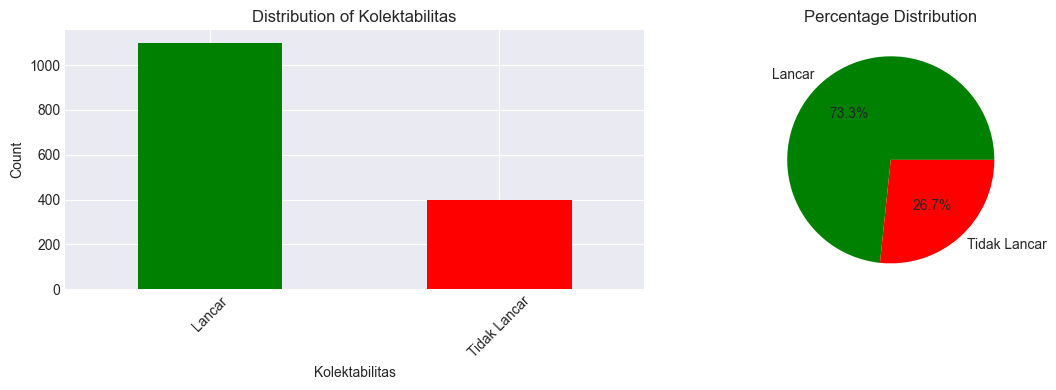

In [35]:
print("TARGET VARIABLE: Kolektabilitas")
print("="*80)
print(f"\nDistribution:")
print(df['Kolektabilitas'].value_counts())
print(f"\nPercentage:")
print(df['Kolektabilitas'].value_counts(normalize=True) * 100)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df['Kolektabilitas'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Distribution of Kolektabilitas')
axes[0].set_xlabel('Kolektabilitas')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

df['Kolektabilitas'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['green', 'red'])
axes[1].set_title('Percentage Distribution')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## 8. Exploratory Data Analysis - Numerical Features

In [36]:
num_features = ['Usia', 'Plafond', 'Jangka Waktu']
print("NUMERICAL FEATURES STATISTICS")
print("="*80)
print(df[num_features].describe())

NUMERICAL FEATURES STATISTICS
              Usia       Plafond  Jangka Waktu
count  1500.000000  1.500000e+03   1500.000000
mean     41.837333  2.196511e+08     92.095333
std       9.953337  2.225929e+08     58.359285
min      19.000000  1.914000e+06      5.000000
25%      34.000000  7.500000e+07     48.750000
50%      42.000000  1.655000e+08     67.000000
75%      49.000000  2.828000e+08    121.000000
max      70.000000  3.000000e+09    240.000000


## 9. Exploratory Data Analysis - Categorical Features

In [37]:
# Categorical features
cat_features = ['Pekerjaan', 'Status Pernikahan', 'Produk', 'Sub Produk', 
                'Hasil Prescreening SLIK', 'Hasil Prescreening SIPKUR', 
                'Hasil Prescreening Dukcapil', 'Hasil Prescreening DHNBI',
                'Hasil Prescreening', 'Status Aplikasi']

print("CATEGORICAL FEATURES SUMMARY")
print("="*80)
for feature in cat_features:
    print(f"\n{feature}:")
    print(df[feature].value_counts())
    print("-"*80)

CATEGORICAL FEATURES SUMMARY

Pekerjaan:
Pekerjaan
Pegawai pemerintahan/lembaga negara              433
Pengajar (Guru,Dosen)                            297
Lain-Lain                                        213
Wiraswasta                                       116
Administrasi umum                                107
Tenaga Medis (Perawat, Bidan, dan sebagainya)     67
Pensiunan                                         48
Eksekutif                                         45
Transportasi darat (masinis, sopir,kondektur)     41
Pengamanan                                        32
Pelajar/Mahasiswa                                 24
Marketing                                         14
Ibu rumah tangga                                   9
Pejabat negara/penyelenggara negara                7
Konsultan/Analis                                   7
Teknologi informasi                                7
Accounting/Finance Officer                         7
Dokter                                          

## 10. Analyze Relationship with Target Variable

In [38]:
# Analyze each categorical feature vs Kolektabilitas
print("RELATIONSHIP: CATEGORICAL FEATURES vs KOLEKTABILITAS")
print("="*80)

for feature in cat_features:
    print(f"\n{feature} vs Kolektabilitas:")
    print("-"*80)
    ct = pd.crosstab(df[feature], df['Kolektabilitas'], margins=True, normalize='index')
    print(ct)
    print()

RELATIONSHIP: CATEGORICAL FEATURES vs KOLEKTABILITAS

Pekerjaan vs Kolektabilitas:
--------------------------------------------------------------------------------
Kolektabilitas                                   Lancar  Tidak Lancar
Pekerjaan                                                            
Accounting/Finance Officer                     0.857143      0.142857
Administrasi umum                              0.757009      0.242991
Buruh (buruh pabrik,buruh bangunan,buruhtani)  1.000000      0.000000
Dokter                                         1.000000      0.000000
Eksekutif                                      0.844444      0.155556
Engineering                                    0.750000      0.250000
Hukum (Pengacara, Notaris)                     0.500000      0.500000
Ibu rumah tangga                               0.777778      0.222222
Konsultan/Analis                               0.285714      0.714286
Lain-Lain                                      0.760563      0.239

## 11. Remove Data Leakage & Prepare Features

Analisis menunjukkan 1 kolom mengandung informasi yang bocorkan target:
1. **Hasil Prescreening SLIK** - High=100% Tidak Lancar, Low/Medium=100% Lancar

Kolom ini akan **DIHAPUS** untuk mencegah overfitting.

In [39]:
# Remove features with data leakage
print("REMOVING FEATURES WITH DATA LEAKAGE & PROBLEMATIC FEATURES")
print("="*80)

leakage_features = [
    "Hasil Prescreening SLIK",
    "Hasil Prescreening",
]

print(f"\nRemoving {len(leakage_features)} features:")
for i, feature in enumerate(leakage_features, 1):
    print(f"  {i}. {feature}")

available_features = [
    "Pekerjaan", 
    "Usia",
    "Status Pernikahan",
    "Produk",
    "Sub Produk",
    "Plafond",
    "Jangka Waktu",
    "Hasil Prescreening SIPKUR",
    "Hasil Prescreening Dukcapil",
    "Hasil Prescreening DHNBI",
    "Status Aplikasi",
]

# Prepare X and y
X = df[available_features].copy()
y = df['Kolektabilitas'].copy()

print(f"\nAvailable features: {len(available_features)}")
print(f"\nFeature list:")
for i, col in enumerate(available_features, 1):
    print(f"{i:2d}. {col}")
print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

REMOVING FEATURES WITH DATA LEAKAGE & PROBLEMATIC FEATURES

Removing 2 features:
  1. Hasil Prescreening SLIK
  2. Hasil Prescreening

Available features: 11

Feature list:
 1. Pekerjaan
 2. Usia
 3. Status Pernikahan
 4. Produk
 5. Sub Produk
 6. Plafond
 7. Jangka Waktu
 8. Hasil Prescreening SIPKUR
 9. Hasil Prescreening Dukcapil
10. Hasil Prescreening DHNBI
11. Status Aplikasi

X shape: (1500, 11)
y shape: (1500,)


## 12. Encode Categorical Features

In [40]:
# Encode categorical features
label_encoders = {}
X_encoded = X.copy()

categorical_columns = X_encoded.select_dtypes(include=['object']).columns

print("ENCODING CATEGORICAL FEATURES")
print("="*80)
for col in categorical_columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"{col}: {len(le.classes_)} categories")

# Encode target
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print(f"\nTarget encoded: {dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))}")
print(f"\nX_encoded shape: {X_encoded.shape}")
print(f"y_encoded shape: {y_encoded.shape}")

ENCODING CATEGORICAL FEATURES
Pekerjaan: 26 categories
Status Pernikahan: 3 categories
Produk: 2 categories
Sub Produk: 4 categories
Hasil Prescreening SIPKUR: 4 categories
Hasil Prescreening Dukcapil: 2 categories
Hasil Prescreening DHNBI: 2 categories
Status Aplikasi: 4 categories

Target encoded: {'Lancar': np.int64(0), 'Tidak Lancar': np.int64(1)}

X_encoded shape: (1500, 11)
y_encoded shape: (1500,)


## 13. Feature Selection

Menggunakan 3 metode feature selection:
1. **Chi-Square Test** - Untuk categorical features
2. **Mutual Information** - Mengukur dependency antara features dan target
3. **Random Forest Feature Importance** - Tree-based feature importance


1. CHI-SQUARE TEST
--------------------------------------------------------------------------------
                    Feature  Chi2_Score      P_Value
            Status Aplikasi  261.356315 8.687099e-59
Hasil Prescreening Dukcapil   58.298701 2.251927e-14
   Hasil Prescreening DHNBI   31.475248 2.019989e-08
                     Produk    2.212969 1.368551e-01
  Hasil Prescreening SIPKUR    1.342741 2.465512e-01
                 Sub Produk    1.253607 2.628647e-01
                  Pekerjaan    0.463563 4.959636e-01
               Jangka Waktu    0.036460 8.485681e-01
                    Plafond    0.005163 9.427208e-01
          Status Pernikahan    0.000288 9.864514e-01
                       Usia    0.000234 9.878059e-01


2. MUTUAL INFORMATION
--------------------------------------------------------------------------------
                    Feature  MI_Score
            Status Aplikasi  0.241136
                     Produk  0.025440
Hasil Prescreening Dukcapil  0.022721
      

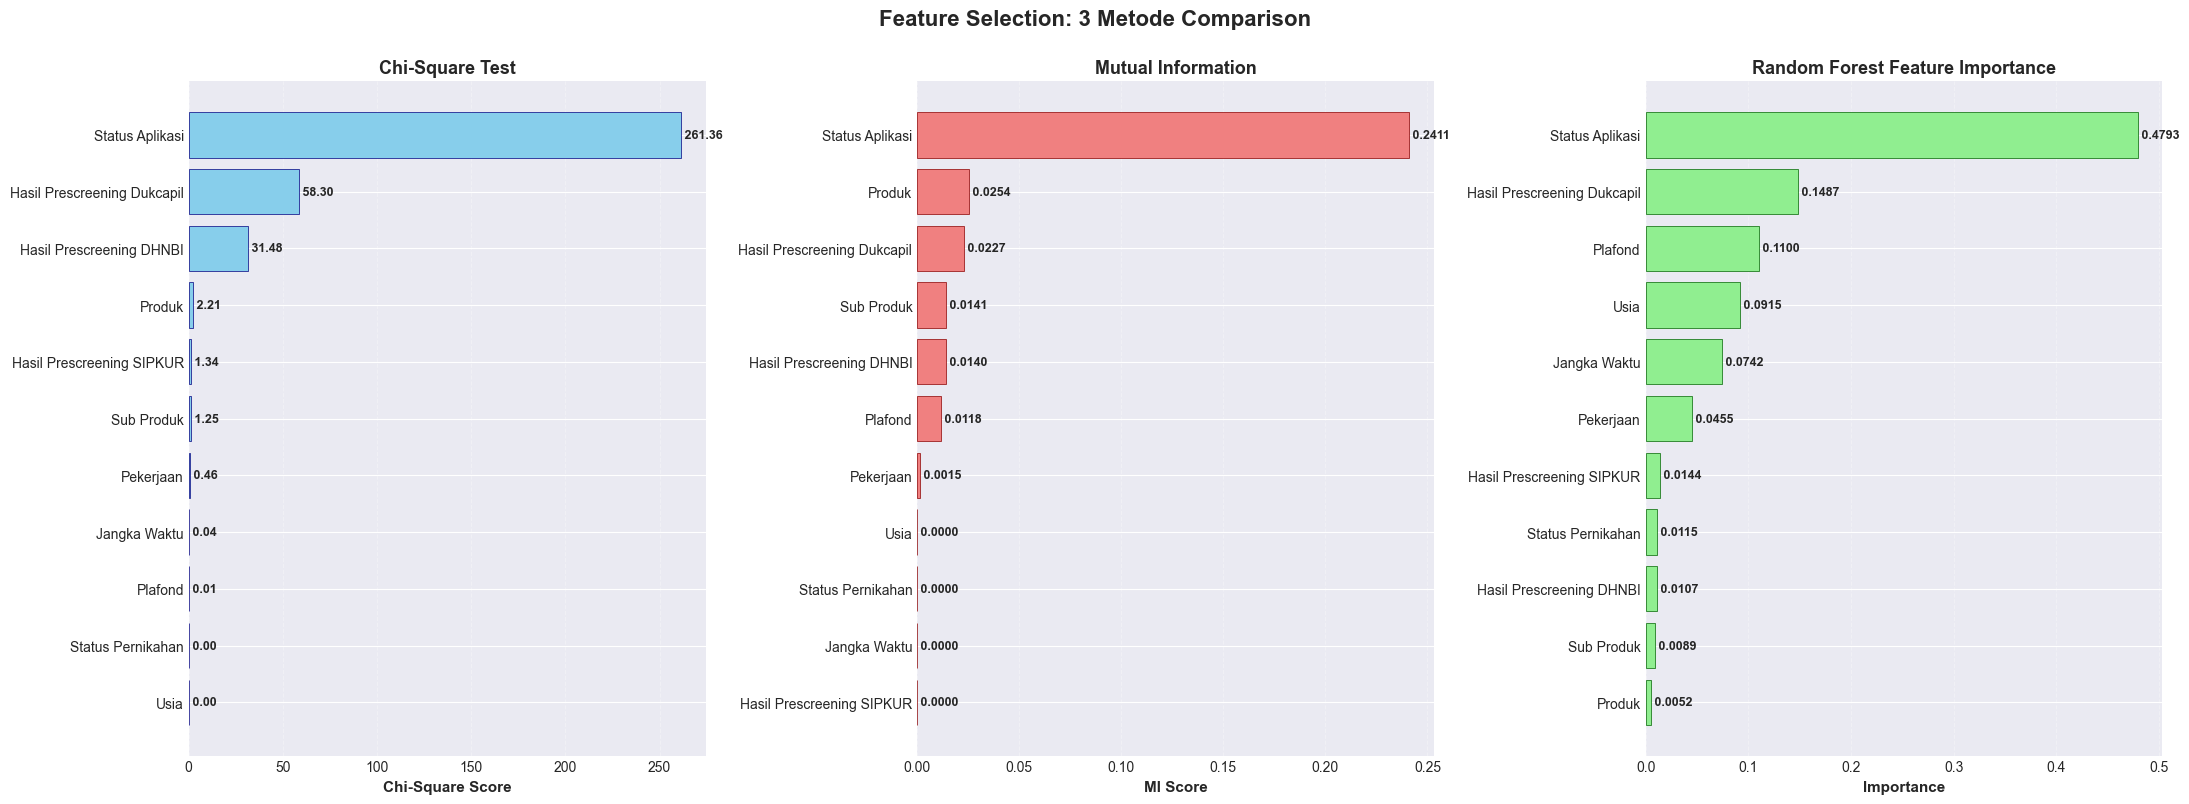


✓ Feature selection analysis complete!


In [41]:
scaler_fs = MinMaxScaler()
X_normalized = scaler_fs.fit_transform(X_encoded)

# 1. Chi-Square Test
print("\n1. CHI-SQUARE TEST")
print("-"*80)
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X_normalized, y_encoded)
chi2_scores = chi2_selector.scores_
chi2_pvalues = chi2_selector.pvalues_

chi2_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Chi2_Score': chi2_scores,
    'P_Value': chi2_pvalues
}).sort_values('Chi2_Score', ascending=False)

print(chi2_df.to_string(index=False))

# 2. Mutual Information
print("\n\n2. MUTUAL INFORMATION")
print("-"*80)
mi_scores = mutual_info_classif(X_encoded, y_encoded, random_state=42)
mi_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print(mi_df.to_string(index=False))

# 3. Random Forest Feature Importance
print("\n\n3. RANDOM FOREST FEATURE IMPORTANCE")
print("-"*80)
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_encoded, y_encoded)
rf_importance = rf_selector.feature_importances_

rf_importance_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_importance
}).sort_values('Importance', ascending=False)

print(rf_importance_df.to_string(index=False))

# Visualisasi dengan label nilai
fig, axes = plt.subplots(1, 3, figsize=(22, 8))
fig.suptitle('Feature Selection: 3 Metode Comparison', fontsize=16, fontweight='bold', y=1.00)

# Chi-Square
bars1 = axes[0].barh(chi2_df['Feature'], chi2_df['Chi2_Score'], color='skyblue', edgecolor='navy', linewidth=0.5)
axes[0].set_xlabel('Chi-Square Score', fontsize=11, fontweight='bold')
axes[0].set_title('Chi-Square Test', fontweight='bold', fontsize=13)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (idx, row) in enumerate(chi2_df.iterrows()):
    axes[0].text(row['Chi2_Score'], i, f' {row["Chi2_Score"]:.2f}', 
                va='center', ha='left', fontsize=9, fontweight='bold')

# Mutual Information
bars2 = axes[1].barh(mi_df['Feature'], mi_df['MI_Score'], color='lightcoral', edgecolor='darkred', linewidth=0.5)
axes[1].set_xlabel('MI Score', fontsize=11, fontweight='bold')
axes[1].set_title('Mutual Information', fontweight='bold', fontsize=13)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (idx, row) in enumerate(mi_df.iterrows()):
    axes[1].text(row['MI_Score'], i, f' {row["MI_Score"]:.4f}', 
                va='center', ha='left', fontsize=9, fontweight='bold')

# Random Forest Importance
bars3 = axes[2].barh(rf_importance_df['Feature'], rf_importance_df['Importance'], color='lightgreen', edgecolor='darkgreen', linewidth=0.5)
axes[2].set_xlabel('Importance', fontsize=11, fontweight='bold')
axes[2].set_title('Random Forest Feature Importance', fontweight='bold', fontsize=13)
axes[2].invert_yaxis()
axes[2].grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (idx, row) in enumerate(rf_importance_df.iterrows()):
    axes[2].text(row['Importance'], i, f' {row["Importance"]:.4f}', 
                va='center', ha='left', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Feature selection analysis complete!")

## 14. Select Best Features Based on Voting

SELECTING BEST FEATURES BASED ON VOTING

COMBINED FEATURE SCORES (Voting dari 3 metode):
                    Feature  Chi2_Normalized  MI_Normalized  RF_Normalized  Average_Score
                  Pekerjaan     1.000000e+00       1.000000       0.479316       0.826439
                       Usia     2.230615e-01       0.105500       0.148729       0.159097
          Status Pernikahan     1.204296e-01       0.094225       0.110028       0.108228
                     Produk     8.466362e-03       0.058384       0.091506       0.052785
                 Sub Produk     5.136697e-03       0.058192       0.074250       0.045860
                    Plafond     4.795653e-03       0.048762       0.045549       0.033035
               Jangka Waktu     1.772789e-03       0.006356       0.014392       0.007507
  Hasil Prescreening SIPKUR     1.386105e-04       0.000000       0.011514       0.003884
Hasil Prescreening Dukcapil     1.885904e-05       0.000000       0.010706       0.003575
   Hasil Pr

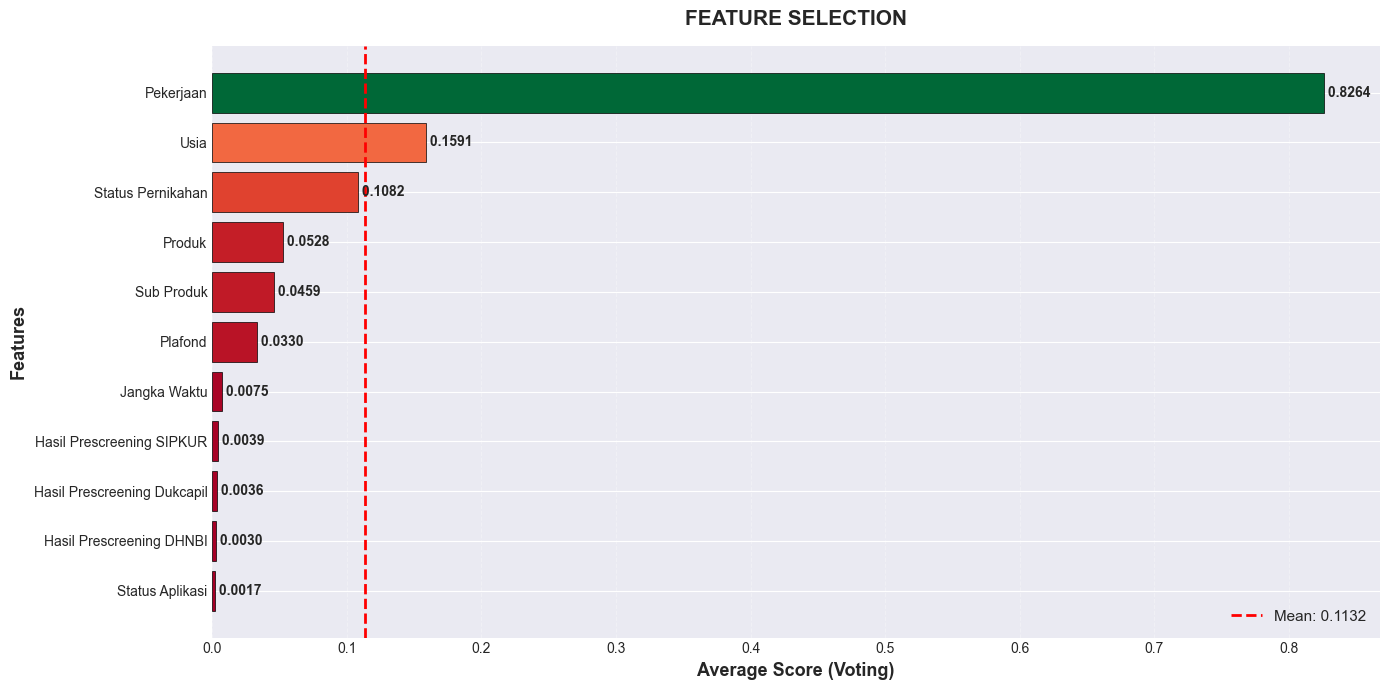



4. RECURSIVE FEATURE ELIMINATION (RFE)
--------------------------------------------------------------------------------
                    Feature  Selected  Ranking
                  Pekerjaan      True        1
                       Usia      True        1
                    Plafond      True        1
               Jangka Waktu      True        1
  Hasil Prescreening SIPKUR      True        1
Hasil Prescreening Dukcapil      True        1
            Status Aplikasi      True        1
          Status Pernikahan     False        2
                 Sub Produk     False        3
   Hasil Prescreening DHNBI     False        4
                     Produk     False        5


FINAL FEATURE SELECTION

 SELECTED FEATURES: 10 dari 11

Features selected by RFE: 7
Features selected by Score: 7
Final union: 10


Final Selected Features (sorted by combined score):
 1. Pekerjaan                           (Score: 0.8264) RFE Score
 2. Usia                                (Score: 0.1591) RFE S

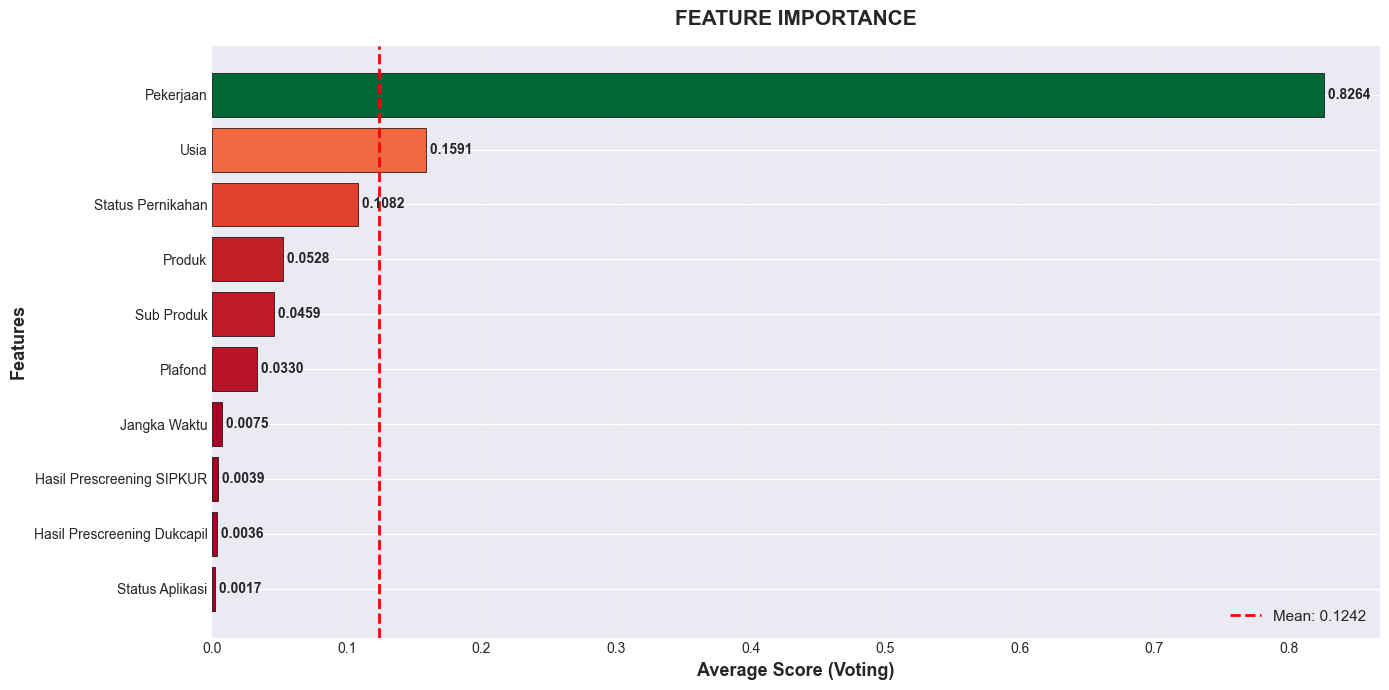

In [42]:
print("SELECTING BEST FEATURES BASED ON VOTING")
print("="*80)

# Normalisasi scores ke range 0-1 untuk setiap metode
from sklearn.preprocessing import MinMaxScaler

# Normalize Chi2 scores
chi2_normalized = MinMaxScaler().fit_transform(chi2_df['Chi2_Score'].values.reshape(-1, 1)).flatten()

# Normalize MI scores  
mi_normalized = MinMaxScaler().fit_transform(mi_df['MI_Score'].values.reshape(-1, 1)).flatten()

# RF importance sudah dalam range 0-1
rf_normalized = rf_importance_df['Importance'].values

# Buat combined dataframe
combined_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Chi2_Normalized': chi2_normalized,
    'MI_Normalized': mi_normalized,
    'RF_Normalized': rf_normalized
})

# Hitung average score dari 3 metode (voting)
combined_df['Average_Score'] = combined_df[['Chi2_Normalized', 'MI_Normalized', 'RF_Normalized']].mean(axis=1)
combined_df = combined_df.sort_values('Average_Score', ascending=False)

print("\nCOMBINED FEATURE SCORES (Voting dari 3 metode):")
print(combined_df.to_string(index=False))

# Visualisasi combined scores dengan label nilai
plt.figure(figsize=(14, 7))

# Create color map based on scores
colors = plt.cm.RdYlGn(combined_df['Average_Score'] / combined_df['Average_Score'].max())

# Create horizontal bar chart
bars = plt.barh(combined_df['Feature'], combined_df['Average_Score'], color=colors, edgecolor='black', linewidth=0.5)

# Add value labels on bars
for i, (idx, row) in enumerate(combined_df.iterrows()):
    plt.text(row['Average_Score'], i, f' {row["Average_Score"]:.4f}', 
             va='center', ha='left', fontsize=10, fontweight='bold')

plt.xlabel('Average Score (Voting)', fontsize=13, fontweight='bold')
plt.ylabel('Features', fontsize=13, fontweight='bold')
plt.title('FEATURE SELECTION', fontsize=15, fontweight='bold', pad=15)
plt.gca().invert_yaxis()

# Add mean line
mean_score = combined_df['Average_Score'].mean()
plt.axvline(x=mean_score, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_score:.4f}')

# Add grid for better readability
plt.grid(axis='x', alpha=0.3, linestyle='--')

plt.legend(fontsize=11, loc='lower right')
plt.tight_layout()
plt.show()

# Strategi: Gunakan RFE untuk memilih top features
print("\n\n4. RECURSIVE FEATURE ELIMINATION (RFE)")
print("-"*80)

# RFE dengan Random Forest
rfe_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
n_features_to_select = max(7, len(X_encoded.columns) // 2)  # Pilih 50% atau minimal 7 features

rfe = RFE(estimator=rfe_model, n_features_to_select=n_features_to_select, step=1)
rfe.fit(X_encoded, y_encoded)

rfe_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Selected': rfe.support_,
    'Ranking': rfe.ranking_
}).sort_values('Ranking')

print(rfe_df.to_string(index=False))

# Pilih features berdasarkan RFE dan Combined Score
print("\n\n" + "="*80)
print("FINAL FEATURE SELECTION")
print("="*80)

# Features yang dipilih RFE
rfe_selected = rfe_df[rfe_df['Selected'] == True]['Feature'].tolist()

# Tambahkan features dengan average score tinggi (backup strategy)
top_features_by_score = combined_df.nlargest(n_features_to_select, 'Average_Score')['Feature'].tolist()

# Gabungkan dengan union (ambil yang dipilih salah satu metode)
selected_features = list(set(rfe_selected) | set(top_features_by_score))

print(f"\n SELECTED FEATURES: {len(selected_features)} dari {len(X_encoded.columns)}")
print(f"\nFeatures selected by RFE: {len(rfe_selected)}")
print(f"Features selected by Score: {len(top_features_by_score)}")
print(f"Final union: {len(selected_features)}")

print("\n\nFinal Selected Features (sorted by combined score):")
final_df = combined_df[combined_df['Feature'].isin(selected_features)].sort_values('Average_Score', ascending=False)
for i, row in enumerate(final_df.itertuples(), 1):
    rfe_mark = "RFE" if row.Feature in rfe_selected else ""
    score_mark = "Score" if row.Feature in top_features_by_score else ""
    print(f"{i:2d}. {row.Feature:35s} (Score: {row.Average_Score:.4f}) {rfe_mark} {score_mark}")

X_selected = X_encoded[selected_features].copy()
feature_columns = selected_features

print(f"\nX_selected shape: {X_selected.shape}")
print(f"Features reduced from {len(X_encoded.columns)} to {len(selected_features)}")



# CREATE VISUALIZATION FOR FEATURE IMPORTANCE BASED ON AVERAGE SCORE
plt.figure(figsize=(14, 7))
colors = plt.cm.RdYlGn(final_df['Average_Score'] / final_df['Average_Score'].max())
bars = plt.barh(final_df['Feature'], final_df['Average_Score'], color=colors, edgecolor='black', linewidth=0.5)

# Add score labels on each bar
for i, (idx, row) in enumerate(final_df.iterrows()):
    plt.text(row['Average_Score'], i, f' {row["Average_Score"]:.4f}', 
             va='center', ha='left', fontsize=10, fontweight='bold')

plt.xlabel('Average Score (Voting)', fontsize=13, fontweight='bold')
plt.ylabel('Features', fontsize=13, fontweight='bold')
plt.title('FEATURE IMPORTANCE', fontsize=15, fontweight='bold', pad=15)
plt.gca().invert_yaxis()

# Add mean line
mean_score = final_df['Average_Score'].mean()
plt.axvline(x=mean_score, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_score:.4f}')

# Add grid for better readability
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.legend(fontsize=11, loc='lower right')
plt.tight_layout()
plt.show()


## 15. Create 3 Train-Test Split Scenarios

Kita akan membuat 3 skenario train-test split dengan **Stratified Random Sampling**:
1. **80-20 Split** - 80% training, 20% testing
2. **70-30 Split** - 70% training, 30% testing
3. **60-40 Split** - 60% training, 40% testing

**Stratified Random Sampling** memastikan proporsi kelas target (Lancar/Tidak Lancar) **sama** di training dan test set.


In [43]:
USE_EXISTING_SPLIT = True  # UBAH KE False JIKA INGIN BUAT SPLIT DATA BARU

split_data_dir = 'DATASET/split_data'
split_file_path = f'{split_data_dir}/train_test_splits.joblib'
metadata_file_path = f'{split_data_dir}/split_metadata.json'

if USE_EXISTING_SPLIT and os.path.exists(split_file_path):
    print("LOADING EXISTING SPLIT DATA")
    print("="*80)
    
    # Load split data
    split_data = joblib.load(split_file_path)
    
    # Extract data
    X_train_80 = split_data['X_train_80']
    X_test_80 = split_data['X_test_80']
    y_train_80 = split_data['y_train_80']
    y_test_80 = split_data['y_test_80']
    
    X_train_70 = split_data['X_train_70']
    X_test_70 = split_data['X_test_70']
    y_train_70 = split_data['y_train_70']
    y_test_70 = split_data['y_test_70']
    
    X_train_60 = split_data['X_train_60']
    X_test_60 = split_data['X_test_60']
    y_train_60 = split_data['y_train_60']
    y_test_60 = split_data['y_test_60']
    
    # X_selected and y_encoded (jika belum ada)
    if 'X_selected' not in locals():
        X_selected = split_data['X_selected']
        y_encoded = split_data['y_encoded']
    
    print(f"✓ Split data loaded from: {split_file_path}")
    print(f"✓ Random state: {split_data['random_state']}")
    
    # Load and display metadata
    if os.path.exists(metadata_file_path):
        with open(metadata_file_path, 'r') as f:
            metadata = json.load(f)
        print(f"✓ Created: {metadata['created_date']}")
        print(f"\nSplit Information:")
        print(f"  80-20: Train={metadata['splits']['80-20']['train_size']}, Test={metadata['splits']['80-20']['test_size']}")
        print(f"  70-30: Train={metadata['splits']['70-30']['train_size']}, Test={metadata['splits']['70-30']['test_size']}")
        print(f"  60-40: Train={metadata['splits']['60-40']['train_size']}, Test={metadata['splits']['60-40']['test_size']}")
    
    print(f"\n{'='*80}")
    print("EXISTING SPLIT DATA LOADED SUCCESSFULLY!")
    print("Data splitting konsisten dengan sebelumnya")
    print("SKIP creating new splits (USE_EXISTING_SPLIT=True)")
    print(f"{'='*80}")
    
    # Set flag to skip creating and saving new splits
    SKIP_CREATE_NEW_SPLIT = True
    
else:
    if USE_EXISTING_SPLIT:
        print("NO EXISTING SPLIT DATA FOUND")
        print("="*80)
        print("Split file tidak ditemukan, akan membuat split baru...")
    else:
        print("CREATING NEW SPLIT DATA")
        print("="*80)
        print("USE_EXISTING_SPLIT=False, akan membuat dan menyimpan split data baru...")
    
    print(f"{'='*80}\n")

    SKIP_CREATE_NEW_SPLIT = False

LOADING EXISTING SPLIT DATA
✓ Split data loaded from: DATASET/split_data/train_test_splits.joblib
✓ Random state: 42
✓ Created: 2026-01-11 15:08:25

Split Information:
  80-20: Train=1200, Test=300
  70-30: Train=1050, Test=450
  60-40: Train=900, Test=600

EXISTING SPLIT DATA LOADED SUCCESSFULLY!
Data splitting konsisten dengan sebelumnya
SKIP creating new splits (USE_EXISTING_SPLIT=True)


In [44]:
# Hanya buat split baru jika tidak menggunakan existing data
if not SKIP_CREATE_NEW_SPLIT:
    print("CREATING 3 TRAIN-TEST SPLIT SCENARIOS")
    print("="*80)
    print("Using STRATIFIED RANDOM SAMPLING to maintain class distribution")
    print("="*80)

    # Scenario 1: 80-20 Split with Stratified Sampling
    X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(
        X_selected, y_encoded, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_encoded  # Stratified sampling mempertahankan proporsi kelas
    )

    print(f"\n1. 80-20 SPLIT (Stratified):")
    print(f"   Training set: {len(X_train_80)} samples ({len(X_train_80)/len(X_selected)*100:.1f}%)")
    print(f"   Test set: {len(X_test_80)} samples ({len(X_test_80)/len(X_selected)*100:.1f}%)")
    print(f"   Training distribution: {dict(zip(*np.unique(y_train_80, return_counts=True)))}")
    print(f"   Test distribution: {dict(zip(*np.unique(y_test_80, return_counts=True)))}")

    # Scenario 2: 70-30 Split with Stratified Sampling
    X_train_70, X_test_70, y_train_70, y_test_70 = train_test_split(
        X_selected, y_encoded, 
        test_size=0.3, 
        random_state=42, 
        stratify=y_encoded  # Stratified sampling mempertahankan proporsi kelas
    )

    print(f"\n2. 70-30 SPLIT (Stratified):")
    print(f"   Training set: {len(X_train_70)} samples ({len(X_train_70)/len(X_selected)*100:.1f}%)")
    print(f"   Test set: {len(X_test_70)} samples ({len(X_test_70)/len(X_selected)*100:.1f}%)")
    print(f"   Training distribution: {dict(zip(*np.unique(y_train_70, return_counts=True)))}")
    print(f"   Test distribution: {dict(zip(*np.unique(y_test_70, return_counts=True)))}")

    # Scenario 3: 60-40 Split with Stratified Sampling
    X_train_60, X_test_60, y_train_60, y_test_60 = train_test_split(
        X_selected, y_encoded, 
        test_size=0.4, 
        random_state=42, 
        stratify=y_encoded  # Stratified sampling mempertahankan proporsi kelas
    )

    print(f"\n3. 60-40 SPLIT (Stratified):")
    print(f"   Training set: {len(X_train_60)} samples ({len(X_train_60)/len(X_selected)*100:.1f}%)")
    print(f"   Test set: {len(X_test_60)} samples ({len(X_test_60)/len(X_selected)*100:.1f}%)")
    print(f"   Training distribution: {dict(zip(*np.unique(y_train_60, return_counts=True)))}")
    print(f"   Test distribution: {dict(zip(*np.unique(y_test_60, return_counts=True)))}")

    print(f"\n{'='*80}")
    print("✓ All 3 stratified train-test split scenarios created successfully!")
    print("✓ Class distribution is maintained in all train and test sets")
    print(f"{'='*80}")
else:
    print("\nSKIP creating new splits (using existing data)")
    print("="*80)


SKIP creating new splits (using existing data)


### Save Split Data to File (For Consistency)

In [45]:
# Hanya save split data jika baru dibuat
if not SKIP_CREATE_NEW_SPLIT:
    print("\nSAVING SPLIT DATA TO FILE")
    print("="*80)

    # Create directory untuk menyimpan split data
    os.makedirs(split_data_dir, exist_ok=True)

    # Simpan semua split dengan random_state=42 untuk konsistensi
    split_data = {
        'X_train_80': X_train_80,
        'X_test_80': X_test_80,
        'y_train_80': y_train_80,
        'y_test_80': y_test_80,
        'X_train_70': X_train_70,
        'X_test_70': X_test_70,
        'y_train_70': y_train_70,
        'y_test_70': y_test_70,
        'X_train_60': X_train_60,
        'X_test_60': X_test_60,
        'y_train_60': y_train_60,
        'y_test_60': y_test_60,
        'X_selected': X_selected,
        'y_encoded': y_encoded,
        'random_state': 42
    }

    # Save ke file
    joblib.dump(split_data, split_file_path)
    print(f"✓ Split data saved to: {split_file_path}")
    print(f"✓ Random state: 42 (untuk konsistensi setiap running)")
    print(f"✓ File size: {os.path.getsize(split_file_path) / 1024:.2f} KB")

    # Save metadata (convert numpy types to Python native types for JSON)
    def convert_to_native(obj):
        """Convert numpy types to native Python types"""
        if isinstance(obj, dict):
            return {str(k): int(v) if isinstance(v, (np.integer, np.int64)) else v for k, v in obj.items()}
        return obj

    split_metadata = {
        'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'random_state': 42,
        'total_samples': int(len(X_selected)),
        'splits': {
            '80-20': {
                'train_size': int(len(X_train_80)),
                'test_size': int(len(X_test_80)),
                'train_distribution': convert_to_native(dict(zip(*np.unique(y_train_80, return_counts=True)))),
                'test_distribution': convert_to_native(dict(zip(*np.unique(y_test_80, return_counts=True))))
            },
            '70-30': {
                'train_size': int(len(X_train_70)),
                'test_size': int(len(X_test_70)),
                'train_distribution': convert_to_native(dict(zip(*np.unique(y_train_70, return_counts=True)))),
                'test_distribution': convert_to_native(dict(zip(*np.unique(y_test_70, return_counts=True))))
            },
            '60-40': {
                'train_size': int(len(X_train_60)),
                'test_size': int(len(X_test_60)),
                'train_distribution': convert_to_native(dict(zip(*np.unique(y_train_60, return_counts=True)))),
                'test_distribution': convert_to_native(dict(zip(*np.unique(y_test_60, return_counts=True))))
            }
        }
    }

    with open(metadata_file_path, 'w') as f:
        json.dump(split_metadata, f, indent=4)
    print(f"✓ Metadata saved to: {metadata_file_path}")

    print(f"\n{'='*80}")
    print("SAVED FILES:")
    print(f"  1. {split_file_path}")
    print(f"  2. {metadata_file_path}")
    print(f"\nKEUNTUNGAN:")
    print(f"  • Data splitting KONSISTEN setiap kali running")
    print(f"  • Tidak perlu running ulang proses splitting")
    print(f"  • Dapat load data langsung untuk training model")
    print(f"  • Random state 42 memastikan reproduksi hasil yang sama")
    print(f"\nTIP:")
    print(f"  • Set USE_EXISTING_SPLIT=True untuk menggunakan split ini di run selanjutnya")
    print(f"  • Set USE_EXISTING_SPLIT=False jika ingin membuat split baru (akan overwrite)")
else:
    print("\n SKIP saving split data (using existing data)")
    print("Jika ingin membuat split data baru, set USE_EXISTING_SPLIT=False")



 SKIP saving split data (using existing data)
Jika ingin membuat split data baru, set USE_EXISTING_SPLIT=False


In [46]:
# Verifikasi metadata split data
if os.path.exists('DATASET/split_data/split_metadata.json'):
    print("VERIFIKASI SPLIT DATA METADATA")
    print("="*80)
    
    with open('DATASET/split_data/split_metadata.json', 'r') as f:
        metadata = json.load(f)
    
    print(f"Created: {metadata['created_date']}")
    print(f"Random State: {metadata['random_state']}")
    print(f"Total Samples: {metadata['total_samples']}")
    
    print(f"\n{'Split Scenario':<20} {'Train Size':<15} {'Test Size':<15} {'Train Dist':<25} {'Test Dist'}")
    print("-" * 100)
    
    for split_name, split_info in metadata['splits'].items():
        train_dist = str(split_info['train_distribution'])
        test_dist = str(split_info['test_distribution'])
        print(f"{split_name:<20} {split_info['train_size']:<15} {split_info['test_size']:<15} {train_dist:<25} {test_dist}")
    
    print("="*80)
    print("Metadata valid dan tersimpan dengan baik")
else:
    print("Metadata file tidak ditemukan. Jalankan cell 'Save Split Data' terlebih dahulu.")

VERIFIKASI SPLIT DATA METADATA
Created: 2026-01-11 15:08:25
Random State: 42
Total Samples: 1500

Split Scenario       Train Size      Test Size       Train Dist                Test Dist
----------------------------------------------------------------------------------------------------
80-20                1200            300             {'0': 880, '1': 320}      {'0': 220, '1': 80}
70-30                1050            450             {'0': 770, '1': 280}      {'0': 330, '1': 120}
60-40                900             600             {'0': 660, '1': 240}      {'0': 440, '1': 160}
Metadata valid dan tersimpan dengan baik


## 16. Feature Scaling for All Scenarios

In [47]:
print("FEATURE SCALING")
print("="*80)

# Scale 80-20 Split
scaler_80 = StandardScaler()
X_train_80_scaled = scaler_80.fit_transform(X_train_80)
X_test_80_scaled = scaler_80.transform(X_test_80)
print("✓ 80-20 split dataset scaled")

# Scale 70-30 Split
scaler_70 = StandardScaler()
X_train_70_scaled = scaler_70.fit_transform(X_train_70)
X_test_70_scaled = scaler_70.transform(X_test_70)
print("✓ 70-30 split dataset scaled")

# Scale 60-40 Split
scaler_60 = StandardScaler()
X_train_60_scaled = scaler_60.fit_transform(X_train_60)
X_test_60_scaled = scaler_60.transform(X_test_60)
print("✓ 60-40 split dataset scaled")


FEATURE SCALING
✓ 80-20 split dataset scaled
✓ 70-30 split dataset scaled
✓ 60-40 split dataset scaled


## 17. K-Fold Cross Validation Setup

K-Fold Cross Validation membagi data menjadi K lipatan dan melatih model K kali.
Setiap kali, 1 lipatan digunakan sebagai test set dan sisanya sebagai training set.

Kita akan menggunakan **10-Fold Stratified Cross Validation**:
- **Stratified** memastikan setiap fold mempertahankan proporsi kelas yang sama
- Lebih robust dan reliable untuk imbalanced dataset

In [48]:
print("K-FOLD CROSS VALIDATION SETUP")
print("="*80)

n_folds = 10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)


scaler_cv = StandardScaler()
X_selected_scaled = scaler_cv.fit_transform(X_selected)

print(f"✓ Using STRATIFIED K-Fold Cross Validation: {n_folds} folds")
print(f"✓ Stratified ensures each fold maintains class distribution")
print(f"✓ Total samples: {len(X_selected)}")
print(f"✓ Approximate samples per fold:")
print(f"   - Training: ~{len(X_selected) * (n_folds-1) / n_folds:.0f} samples ({(n_folds-1)/n_folds*100:.0f}%)")
print(f"   - Validation: ~{len(X_selected) / n_folds:.0f} samples ({100/n_folds:.0f}%)")


K-FOLD CROSS VALIDATION SETUP
✓ Using STRATIFIED K-Fold Cross Validation: 10 folds
✓ Stratified ensures each fold maintains class distribution
✓ Total samples: 1500
✓ Approximate samples per fold:
   - Training: ~1350 samples (90%)
   - Validation: ~150 samples (10%)


## 18. Model Training with 4 Scenarios

Melatih **4 model** (Random Forest, XGBoost, LightGBM, Gradient Boosting) dengan **4 skenario**:
1. **80-20 Split** - 80% training, 20% testing
2. **70-30 Split** - 70% training, 30% testing
3. **60-40 Split** - 60% training, 40% testing
4. **10-Fold CV** - K-Fold Cross Validation

Total: **16 kombinasi**

In [49]:
print("TRAINING MODELS WITH 4 SCENARIOS")
print("="*80)

all_results = []

split_scenarios = {
    '80-20 Split': (X_train_80_scaled, y_train_80, X_test_80_scaled, y_test_80),
    '70-30 Split': (X_train_70_scaled, y_train_70, X_test_70_scaled, y_test_70),
    '60-40 Split': (X_train_60_scaled, y_train_60, X_test_60_scaled, y_test_60)
}

model_configs = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        verbose=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
}

# ===========================
# SCENARIO 1-3: Train-Test Split
# ===========================
for scenario_name, (X_tr, y_tr, X_te, y_te) in split_scenarios.items():
    print(f"\n{'='*80}")
    print(f"SCENARIO: {scenario_name}")
    print(f"{'='*80}")
    print(f"Training size: {len(X_tr)}, Test size: {len(X_te)}")
    
    for model_name, model_config in model_configs.items():
        print(f"\n  Training {model_name}...")
        
        # Clone model
        from sklearn.base import clone
        model = clone(model_config)
        
        # Train
        model.fit(X_tr, y_tr)
        
        # Predict
        y_pred = model.predict(X_te)
        y_pred_proba = model.predict_proba(X_te)[:, 1]
        
        # Evaluate
        accuracy = accuracy_score(y_te, y_pred)
        precision = precision_score(y_te, y_pred, zero_division=0)
        recall = recall_score(y_te, y_pred, zero_division=0)
        f1 = f1_score(y_te, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_te, y_pred_proba)
        
        # Store results
        all_results.append({
            'Scenario': scenario_name,
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc,
            'model_object': model
        })
        
        print(f"    ✓ {model_name:20s} | Acc: {accuracy:.4f} | Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f} | AUC: {roc_auc:.4f}")

# ===========================
# SCENARIO 4: K-Fold Cross Validation
# ===========================
print(f"\n{'='*80}")
print(f"SCENARIO: 10-Fold Cross Validation")
print(f"{'='*80}")

for model_name, model_config in model_configs.items():
    print(f"\n  Training {model_name} with 10-Fold CV...")
    
    from sklearn.base import clone
    model = clone(model_config)
    
    # Perform cross-validation
    cv_scores_accuracy = cross_val_score(model, X_selected_scaled, y_encoded, cv=skf, scoring='accuracy', n_jobs=-1)
    cv_scores_precision = cross_val_score(model, X_selected_scaled, y_encoded, cv=skf, scoring='precision', n_jobs=-1)
    cv_scores_recall = cross_val_score(model, X_selected_scaled, y_encoded, cv=skf, scoring='recall', n_jobs=-1)
    cv_scores_f1 = cross_val_score(model, X_selected_scaled, y_encoded, cv=skf, scoring='f1', n_jobs=-1)
    cv_scores_roc_auc = cross_val_score(model, X_selected_scaled, y_encoded, cv=skf, scoring='roc_auc', n_jobs=-1)
    
    accuracy = cv_scores_accuracy.mean()
    precision = cv_scores_precision.mean()
    recall = cv_scores_recall.mean()
    f1 = cv_scores_f1.mean()
    roc_auc = cv_scores_roc_auc.mean()
   
    model.fit(X_selected_scaled, y_encoded)
    
    all_results.append({
        'Scenario': '10-Fold CV',
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'model_object': model
    })
    
    print(f"    ✓ {model_name:20s} | Acc: {accuracy:.4f} | Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f} | AUC: {roc_auc:.4f}")


TRAINING MODELS WITH 4 SCENARIOS

SCENARIO: 80-20 Split
Training size: 1200, Test size: 300

  Training Random Forest...


    ✓ Random Forest        | Acc: 0.9200 | Prec: 0.7979 | Rec: 0.9375 | F1: 0.8621 | AUC: 0.9456

  Training XGBoost...
    ✓ XGBoost              | Acc: 0.9100 | Prec: 0.7849 | Rec: 0.9125 | F1: 0.8439 | AUC: 0.9448

  Training LightGBM...
    ✓ LightGBM             | Acc: 0.9200 | Prec: 0.7979 | Rec: 0.9375 | F1: 0.8621 | AUC: 0.9474

  Training Gradient Boosting...
    ✓ Gradient Boosting    | Acc: 0.9167 | Prec: 0.7957 | Rec: 0.9250 | F1: 0.8555 | AUC: 0.9469

SCENARIO: 70-30 Split
Training size: 1050, Test size: 450

  Training Random Forest...
    ✓ Random Forest        | Acc: 0.9200 | Prec: 0.7800 | Rec: 0.9750 | F1: 0.8667 | AUC: 0.9492

  Training XGBoost...
    ✓ XGBoost              | Acc: 0.9133 | Prec: 0.7755 | Rec: 0.9500 | F1: 0.8539 | AUC: 0.9505

  Training LightGBM...
    ✓ LightGBM             | Acc: 0.9178 | Prec: 0.7823 | Rec: 0.9583 | F1: 0.8614 | AUC: 0.9514

  Training Gradient Boosting...
    ✓ Gradient Boosting    | Acc: 0.9133 | Prec: 0.7832 | Rec: 0.9333 | F

## 19. Comprehensive Comparison Results

In [50]:
# Create comparison dataframe
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.drop('model_object', axis=1)

# Sort by ROC-AUC (highest first) for display
comparison_df_sorted = comparison_df.sort_values('ROC-AUC', ascending=False)

print("COMPLETE COMPARISON: ALL MODELS × ALL SCENARIOS (Sorted by ROC-AUC)")
print("="*80)
print(comparison_df_sorted.to_string(index=False))

# Summary by Scenario
print(f"\n\nSUMMARY BY SCENARIO (Average Metrics):")
print("="*80)
scenario_summary = comparison_df.groupby('Scenario')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].mean()
print(scenario_summary)

# Summary by Model
print(f"\n\nSUMMARY BY MODEL (Average Metrics):")
print("="*80)
model_summary = comparison_df.groupby('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].mean()
print(model_summary)

# Best model overall
best_idx = comparison_df['ROC-AUC'].idxmax()
best_result = comparison_df.loc[best_idx]
print(f"\n\n🏆 BEST MODEL:")
print("="*80)
print(f"Scenario: {best_result['Scenario']}")
print(f"Model: {best_result['Model']}")
print(f"Accuracy:  {best_result['Accuracy']:.4f}")
print(f"Precision: {best_result['Precision']:.4f}")
print(f"Recall:    {best_result['Recall']:.4f}")
print(f"F1-Score:  {best_result['F1-Score']:.4f}")
print(f"ROC-AUC:   {best_result['ROC-AUC']:.4f}")

COMPLETE COMPARISON: ALL MODELS × ALL SCENARIOS (Sorted by ROC-AUC)
   Scenario             Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
60-40 Split     Random Forest  0.921667   0.781095 0.981250  0.869806 0.954972
60-40 Split Gradient Boosting  0.915000   0.794595 0.918750  0.852174 0.954524
60-40 Split           XGBoost  0.916667   0.789474 0.937500  0.857143 0.953445
60-40 Split          LightGBM  0.915000   0.788360 0.931250  0.853868 0.953445
70-30 Split Gradient Boosting  0.913333   0.783217 0.933333  0.851711 0.953194
 10-Fold CV           XGBoost  0.916000   0.787289 0.947500  0.858393 0.952420
 10-Fold CV          LightGBM  0.914667   0.788786 0.935000  0.854791 0.951773
70-30 Split          LightGBM  0.917778   0.782313 0.958333  0.861423 0.951389
 10-Fold CV     Random Forest  0.914000   0.782276 0.945000  0.855323 0.950659
70-30 Split           XGBoost  0.913333   0.775510 0.950000  0.853933 0.950530
70-30 Split     Random Forest  0.920000   0.780000 0.975000  0.

## 20. Visualization - Comparison Across Scenarios & Models

### Visualization 2: Heatmap Comparison

CREATING CONFUSION MATRIX FOR BEST MODELS


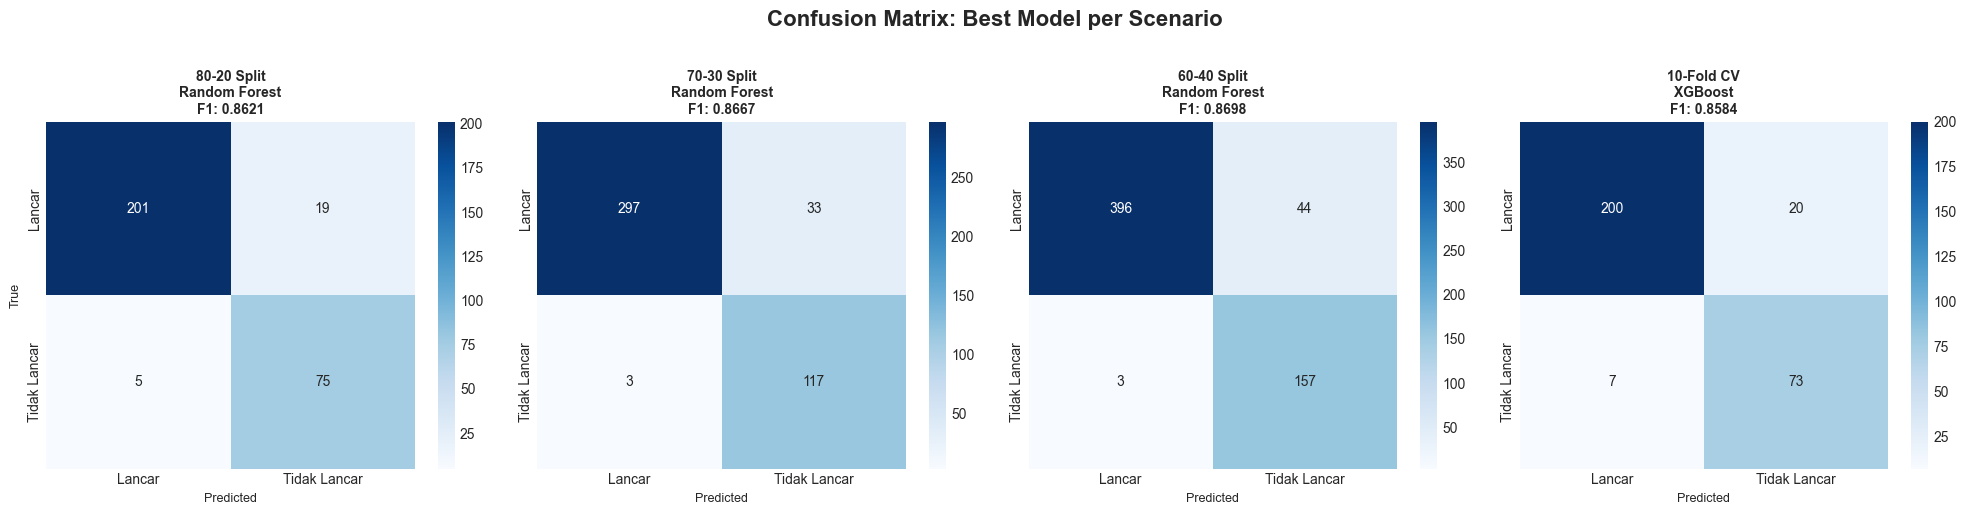


✓ Confusion matrix comparison complete!


In [51]:
# Confusion Matrix untuk best model dari setiap scenario
print("CREATING CONFUSION MATRIX FOR BEST MODELS")
print("="*80)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Confusion Matrix: Best Model per Scenario', fontsize=16, fontweight='bold', y=1.02)

scenarios_dict = {
    '80-20 Split': (X_train_80_scaled, X_test_80_scaled, y_train_80, y_test_80),
    '70-30 Split': (X_train_70_scaled, X_test_70_scaled, y_train_70, y_test_70),
    '60-40 Split': (X_train_60_scaled, X_test_60_scaled, y_train_60, y_test_60)
}

for idx, (scenario_name, (X_tr, X_te, y_tr, y_te)) in enumerate(scenarios_dict.items()):
    # Cari best model untuk scenario ini
    best_row = comparison_df[comparison_df['Scenario'] == scenario_name].sort_values('F1-Score', ascending=False).iloc[0]
    best_model_name = best_row['Model']
    
    # Train ulang best model
    if best_model_name == 'Random Forest':
        model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=10, min_samples_leaf=4, random_state=42, n_jobs=-1)
    elif best_model_name == 'Gradient Boosting':
        model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    elif best_model_name == 'XGBoost':
        model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='logloss', use_label_encoder=False)
    else:  # LightGBM
        model = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1)
    
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    
    # Buat confusion matrix
    cm = confusion_matrix(y_te, y_pred)
    
    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                xticklabels=['Lancar', 'Tidak Lancar'],
                yticklabels=['Lancar', 'Tidak Lancar'])
    
    axes[idx].set_title(f'{scenario_name}\n{best_model_name}\nF1: {best_row["F1-Score"]:.4f}', 
                        fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=9)
    axes[idx].set_ylabel('True' if idx == 0 else '', fontsize=9)

# Confusion matrix for 10-Fold CV (use 80-20 split as representative)
best_row_cv = comparison_df[comparison_df['Scenario'] == '10-Fold CV'].sort_values('F1-Score', ascending=False).iloc[0]
best_model_name_cv = best_row_cv['Model']

if best_model_name_cv == 'Random Forest':
    model_cv = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=10, min_samples_leaf=4, random_state=42, n_jobs=-1)
elif best_model_name_cv == 'Gradient Boosting':
    model_cv = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
elif best_model_name_cv == 'XGBoost':
    model_cv = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='logloss', use_label_encoder=False)
else:  # LightGBM
    model_cv = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1)

# Use 80-20 split for visualization
model_cv.fit(X_train_80_scaled, y_train_80)
y_pred_cv = model_cv.predict(X_test_80_scaled)
cm_cv = confusion_matrix(y_test_80, y_pred_cv)

sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues', ax=axes[3], 
            xticklabels=['Lancar', 'Tidak Lancar'],
            yticklabels=['Lancar', 'Tidak Lancar'])

axes[3].set_title(f'10-Fold CV\n{best_model_name_cv}\nF1: {best_row_cv["F1-Score"]:.4f}', 
                  fontsize=10, fontweight='bold')
axes[3].set_xlabel('Predicted', fontsize=9)
axes[3].set_ylabel('', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ Confusion matrix comparison complete!")

### Visualization 4: ROC Curve Comparison

CREATING ROC CURVE COMPARISON


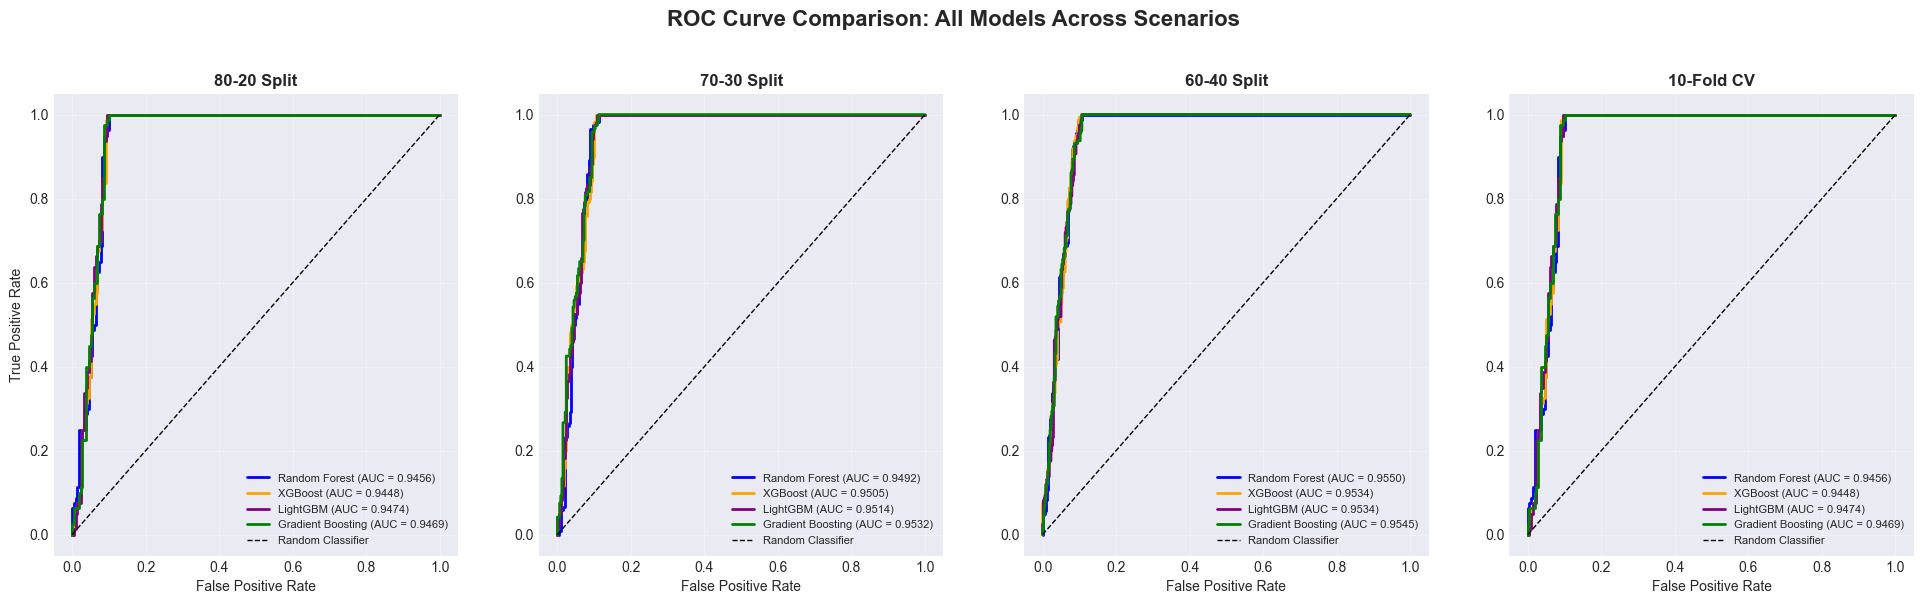

In [52]:
# ROC Curve comparison untuk semua kombinasi
print("CREATING ROC CURVE COMPARISON")
print("="*80)

fig, axes = plt.subplots(1, 4, figsize=(24, 6))
fig.suptitle('ROC Curve Comparison: All Models Across Scenarios', fontsize=16, fontweight='bold', y=1.02)

colors = {'Random Forest': 'blue', 'XGBoost': 'orange', 'LightGBM': 'purple', 'Gradient Boosting': 'green'}

scenarios_dict = {
    '80-20 Split': (X_train_80_scaled, X_test_80_scaled, y_train_80, y_test_80),
    '70-30 Split': (X_train_70_scaled, X_test_70_scaled, y_train_70, y_test_70),
    '60-40 Split': (X_train_60_scaled, X_test_60_scaled, y_train_60, y_test_60)
}

for idx, (scenario_name, (X_tr, X_te, y_tr, y_te)) in enumerate(scenarios_dict.items()):
    ax = axes[idx]
    
    for model_name in ['Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting']:
        # Train model
        if model_name == 'Random Forest':
            model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=10, min_samples_leaf=4, random_state=42, n_jobs=-1)
        elif model_name == 'XGBoost':
            model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='logloss', use_label_encoder=False)
        elif model_name == 'LightGBM':
            model = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1)
        else:  # Gradient Boosting
            model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
        
        model.fit(X_tr, y_tr)
        y_pred_proba = model.predict_proba(X_te)[:, 1]
        
        # Hitung ROC curve
        fpr, tpr, _ = roc_curve(y_te, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot
        ax.plot(fpr, tpr, color=colors[model_name], lw=2, 
                label=f'{model_name} (AUC = {roc_auc:.4f})')
    
    # Plot diagonal
    ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')
    
    ax.set_xlabel('False Positive Rate', fontsize=10)
    ax.set_ylabel('True Positive Rate' if idx == 0 else '', fontsize=10)
    ax.set_title(f'{scenario_name}', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(alpha=0.3)

# ROC for 10-Fold CV (use 80-20 split as representative)
ax = axes[3]
for model_name in ['Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting']:
    if model_name == 'Random Forest':
        model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=10, min_samples_leaf=4, random_state=42, n_jobs=-1)
    elif model_name == 'XGBoost':
        model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='logloss', use_label_encoder=False)
    elif model_name == 'LightGBM':
        model = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1)
    else:
        model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    
    model.fit(X_train_80_scaled, y_train_80)
    y_pred_proba = model.predict_proba(X_test_80_scaled)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test_80, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color=colors[model_name], lw=2, 
            label=f'{model_name} (AUC = {roc_auc:.4f})')

ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_ylabel('', fontsize=10)
ax.set_title(f'10-Fold CV', fontsize=12, fontweight='bold')
ax.legend(loc='lower right', fontsize=8)
ax.grid(alpha=0.3)

# plt.tight_layout()
# plt.show()


### Visualization 5: Feature Importance Analysis

FEATURE IMPORTANCE ANALYSIS


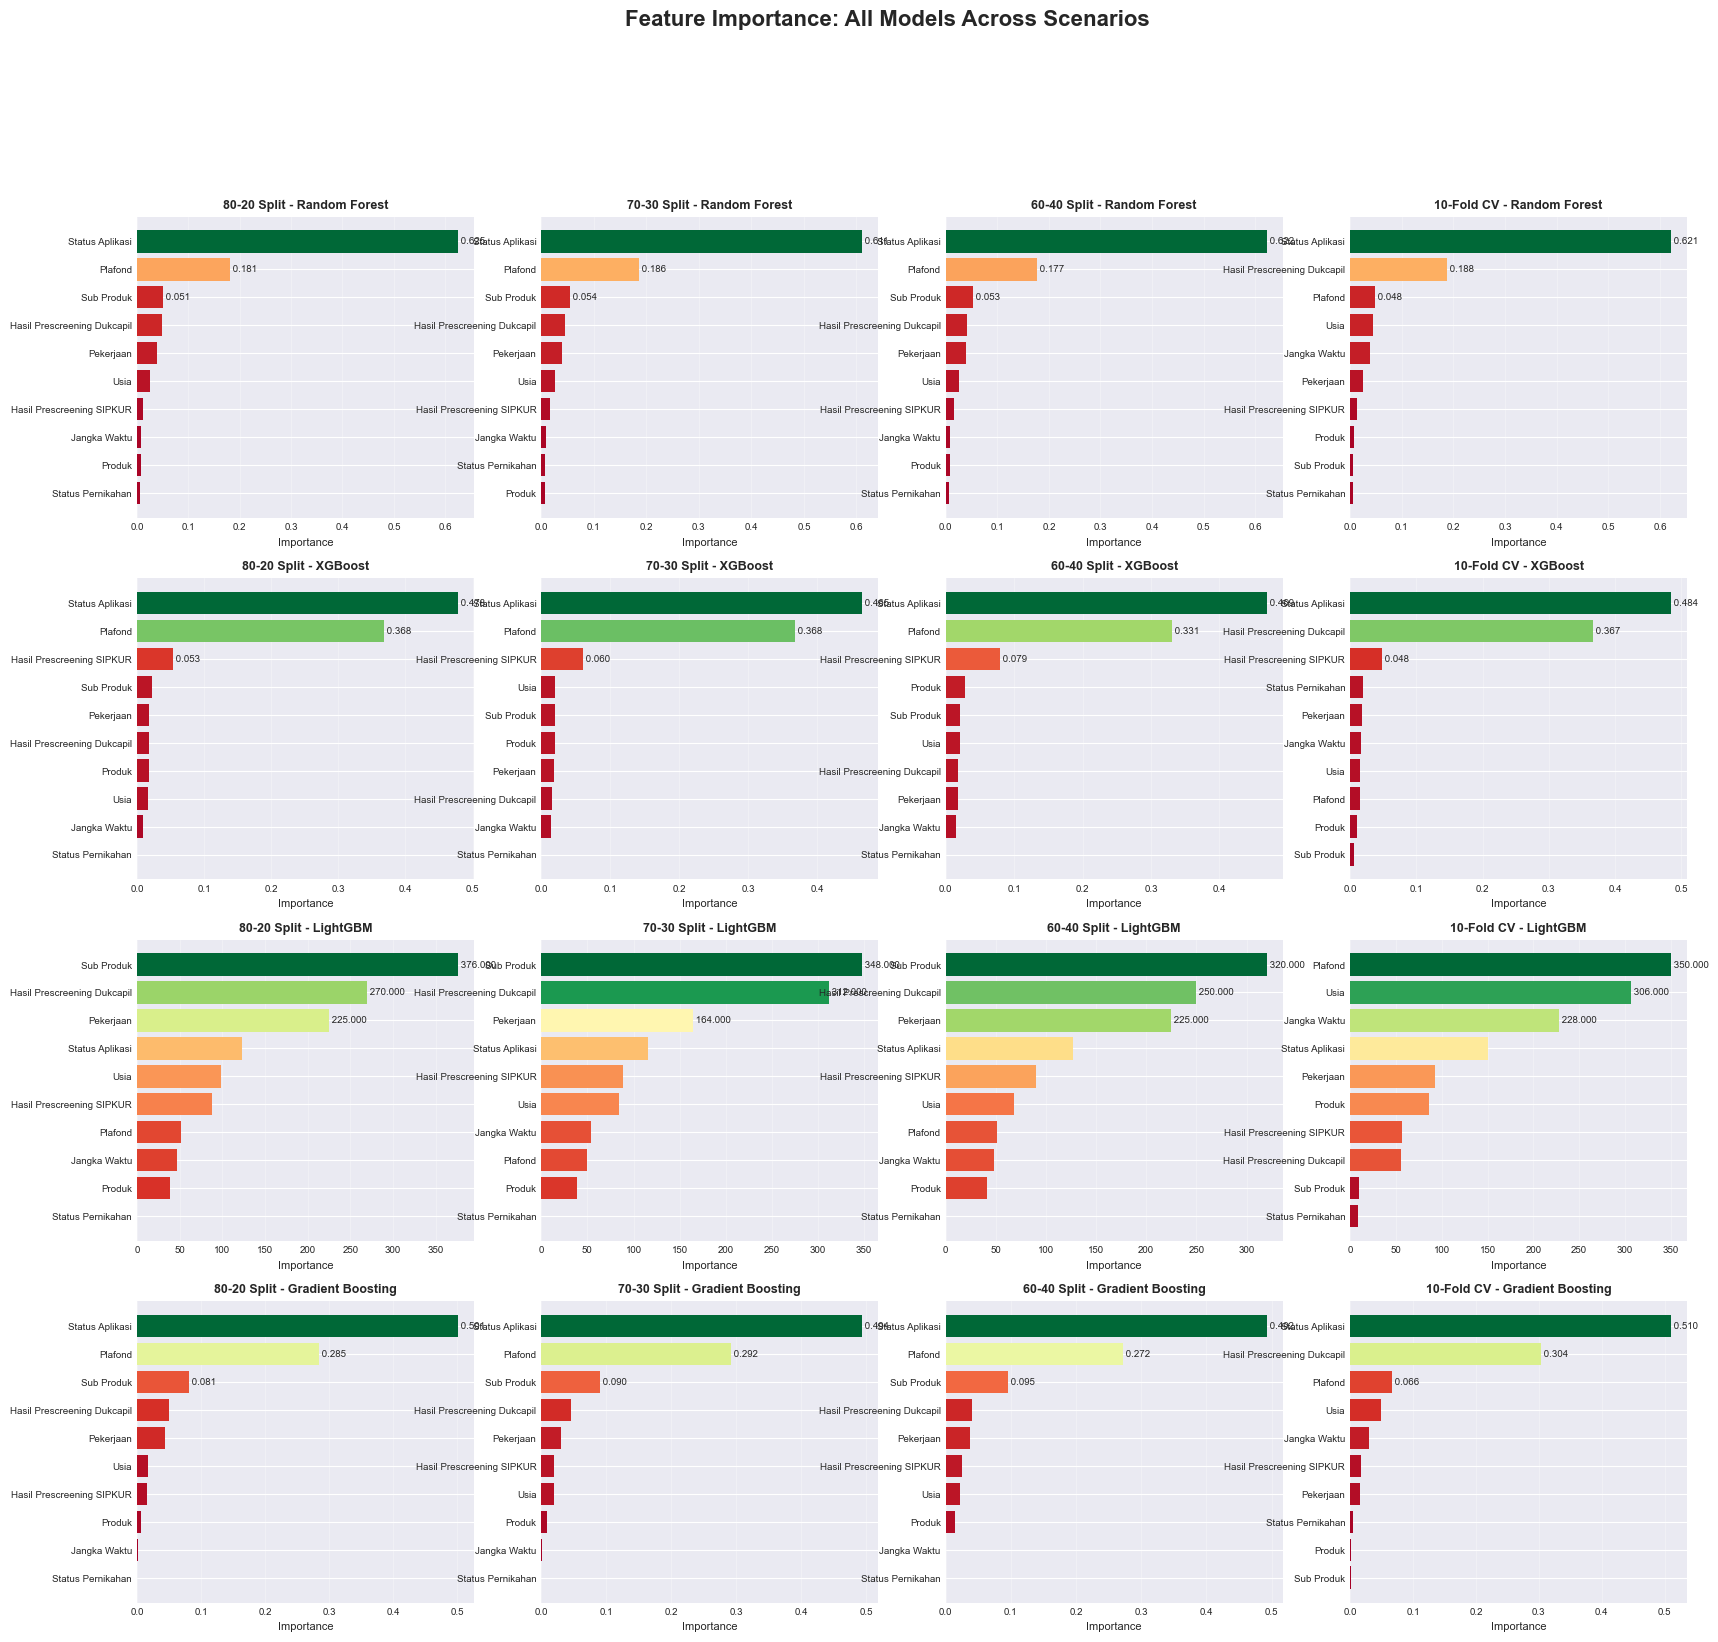

In [53]:
# Feature Importance untuk semua model yang support feature_importances_
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

fig, axes = plt.subplots(4, 4, figsize=(20, 18))
fig.suptitle('Feature Importance: All Models Across Scenarios', fontsize=16, fontweight='bold', y=0.995)

scenarios_dict = {
    '80-20 Split': (X_train_80_scaled, X_test_80_scaled, y_train_80, y_test_80),
    '70-30 Split': (X_train_70_scaled, X_test_70_scaled, y_train_70, y_test_70),
    '60-40 Split': (X_train_60_scaled, X_test_60_scaled, y_train_60, y_test_60),
    '10-Fold CV': (X_selected_scaled, None, y_encoded, None)
}

model_configs = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=10, min_samples_leaf=4, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='logloss', use_label_encoder=False),
    'LightGBM': LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
}

for col_idx, (scenario_name, (X_tr, X_te, y_tr, y_te)) in enumerate(scenarios_dict.items()):
    for row_idx, (model_name, model) in enumerate(model_configs.items()):
        ax = axes[row_idx, col_idx]
        
        # Train model
        from sklearn.base import clone
        trained_model = clone(model)
        trained_model.fit(X_tr, y_tr)
        
        # Get feature importance
        if hasattr(trained_model, 'feature_importances_'):
            importances = trained_model.feature_importances_
            
            # Create dataframe
            feature_imp_df = pd.DataFrame({
                'Feature': selected_features,
                'Importance': importances
            }).sort_values('Importance', ascending=True)
            
            # Plot horizontal bar
            colors_bar = plt.cm.RdYlGn(feature_imp_df['Importance'] / feature_imp_df['Importance'].max())
            ax.barh(feature_imp_df['Feature'], feature_imp_df['Importance'], color=colors_bar)
            ax.set_xlabel('Importance', fontsize=8)
            ax.set_title(f'{scenario_name} - {model_name}', fontsize=9, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            ax.tick_params(axis='both', labelsize=7)
            
            # Add value labels untuk top 3
            for i in range(min(3, len(feature_imp_df))):
                row = feature_imp_df.iloc[-(i+1)]
                ax.text(row['Importance'], len(feature_imp_df) - i - 1, f' {row["Importance"]:.3f}', 
                       va='center', fontsize=7)

# plt.tight_layout()
# plt.show()


### Visualization 6: Top 5 Features Comparison


TOP 5 FEATURES PER MODEL-SCENARIO COMBINATION

80-20 Split:
--------------------------------------------------------------------------------

  Random Forest:
    1. Status Aplikasi                (0.6246)
    2. Plafond                        (0.1805)
    3. Sub Produk                     (0.0509)
    4. Hasil Prescreening Dukcapil    (0.0489)
    5. Pekerjaan                      (0.0386)

  XGBoost:
    1. Status Aplikasi                (0.4781)
    2. Plafond                        (0.3683)
    3. Hasil Prescreening SIPKUR      (0.0531)
    4. Sub Produk                     (0.0217)
    5. Pekerjaan                      (0.0184)

  LightGBM:
    1. Sub Produk                     (376.0000)
    2. Hasil Prescreening Dukcapil    (270.0000)
    3. Pekerjaan                      (225.0000)
    4. Status Aplikasi                (123.0000)
    5. Usia                           (99.0000)

  Gradient Boosting:
    1. Status Aplikasi                (0.5011)
    2. Plafond                  

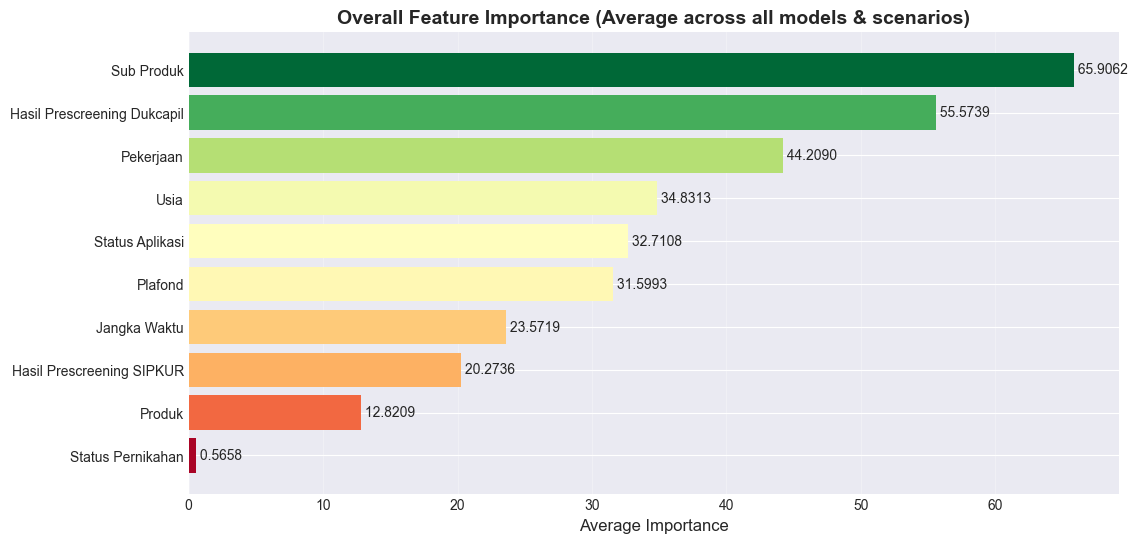

In [54]:
# Summary: Top 5 features untuk setiap kombinasi
print("\nTOP 5 FEATURES PER MODEL-SCENARIO COMBINATION")
print("="*80)

scenarios_dict = {
    '80-20 Split': (X_train_80_scaled, X_test_80_scaled, y_train_80, y_test_80),
    '70-30 Split': (X_train_70_scaled, X_test_70_scaled, y_train_70, y_test_70),
    '60-40 Split': (X_train_60_scaled, X_test_60_scaled, y_train_60, y_test_60),
    '10-Fold CV': (X_selected_scaled, None, y_encoded, None)
}

model_configs = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=10, min_samples_leaf=4, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='logloss', use_label_encoder=False),
    'LightGBM': LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
}

for scenario_name, (X_tr, X_te, y_tr, y_te) in scenarios_dict.items():
    print(f"\n{scenario_name}:")
    print("-"*80)
    
    for model_name, model in model_configs.items():
        from sklearn.base import clone
        trained_model = clone(model)
        trained_model.fit(X_tr, y_tr)
        
        if hasattr(trained_model, 'feature_importances_'):
            importances = trained_model.feature_importances_
            
            feature_imp_df = pd.DataFrame({
                'Feature': selected_features,
                'Importance': importances
            }).sort_values('Importance', ascending=False).head(5)
            
            print(f"\n  {model_name}:")
            for idx, (i, row) in enumerate(feature_imp_df.iterrows(), 1):
                print(f"    {idx}. {row['Feature']:30s} ({row['Importance']:.4f})")

# Overall feature importance (average across all models and scenarios)
print("\n\n" + "="*80)
print("OVERALL FEATURE IMPORTANCE (Average across all combinations)")
print("="*80)

all_importances = []

for scenario_name, (X_tr, X_te, y_tr, y_te) in scenarios_dict.items():
    for model_name, model in model_configs.items():
        from sklearn.base import clone
        trained_model = clone(model)
        trained_model.fit(X_tr, y_tr)
        
        if hasattr(trained_model, 'feature_importances_'):
            all_importances.append(trained_model.feature_importances_)

# Calculate average importance
avg_importances = np.mean(all_importances, axis=0)
overall_imp_df = pd.DataFrame({
    'Feature': selected_features,
    'Average_Importance': avg_importances
}).sort_values('Average_Importance', ascending=False)

print("\nRanking:")
for idx, (i, row) in enumerate(overall_imp_df.iterrows(), 1):
    print(f"{idx:2d}. {row['Feature']:30s} {row['Average_Importance']:.4f}")

# Visualize overall importance
plt.figure(figsize=(12, 6))
colors_bar = plt.cm.RdYlGn(overall_imp_df['Average_Importance'] / overall_imp_df['Average_Importance'].max())
plt.barh(overall_imp_df['Feature'], overall_imp_df['Average_Importance'], color=colors_bar)
plt.xlabel('Average Importance', fontsize=12)
plt.title('Overall Feature Importance (Average across all models & scenarios)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(overall_imp_df.iterrows()):
    plt.text(row['Average_Importance'], i, f' {row["Average_Importance"]:.4f}', 
            va='center', fontsize=10)

# plt.tight_layout()
# plt.show()


## 21. Final Recommendation & Best Scenario Selection

In [55]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

print("HYPERPARAMETER TUNING - BEST MODEL WITH BEST SCENARIO DATASET")
print("="*80)

# Step 1: Identifikasi best model dan best scenario berdasarkan ROC-AUC
best_overall = comparison_df.sort_values('ROC-AUC', ascending=False).iloc[0]
best_model_name = best_overall['Model']
best_scenario = best_overall['Scenario']

print(f" BEST MODEL & SCENARIO SELECTION")
print(f"{'='*80}")
print(f"✓ Best Model: {best_model_name}")
print(f"✓ Best Scenario Dataset: {best_scenario}")
print(f"✓ ROC-AUC Before Tuning: {best_overall['ROC-AUC']:.4f}")
print(f"✓ F1-Score Before Tuning: {best_overall['F1-Score']:.4f}")
print(f"{'='*80}")

# Step 2: Gunakan data dari scenario terbaik untuk hyperparameter tuning
print(f"\n USING BEST SCENARIO DATASET FOR TUNING")
print(f"{'='*80}")
print(f"Dataset yang digunakan: {best_scenario}")

# Tentukan data yang digunakan berdasarkan scenario
if best_scenario == '80-20 Split':
    X_tune_train, X_tune_test = X_train_80_scaled, X_test_80_scaled
    y_tune_train, y_tune_test = y_train_80, y_test_80
    scaler_tune = scaler_80
elif best_scenario == '70-30 Split':
    X_tune_train, X_tune_test = X_train_70_scaled, X_test_70_scaled
    y_tune_train, y_tune_test = y_train_70, y_test_70
    scaler_tune = scaler_70
elif best_scenario == '60-40 Split':
    X_tune_train, X_tune_test = X_train_60_scaled, X_test_60_scaled
    y_tune_train, y_tune_test = y_train_60, y_test_60
    scaler_tune = scaler_60
else:  # 10-Fold CV
    X_tune_train, X_tune_test = X_selected_scaled, None
    y_tune_train, y_tune_test = y_encoded, None
    scaler_tune = scaler_cv

print(f"\nTraining data size: {len(X_tune_train)}")
if X_tune_test is not None:
    print(f"Test data size: {len(X_tune_test)}")

# Define parameter grids untuk setiap model
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20, 25, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 9],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 9, -1],
        'num_leaves': [31, 50, 70],
        'min_child_samples': [10, 20, 30],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 9],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.6, 0.8, 1.0],
        'max_features': ['sqrt', 'log2', None]
    }
}

print(f"\n{'='*80}")
print(f"GRID SEARCH WITH 5-FOLD STRATIFIED CROSS VALIDATION")
print(f"{'='*80}")
print(f"Model: {best_model_name}")
print(f"Parameters to tune: {len(param_grids[best_model_name])} parameters")
print(f"Scoring metric: ROC-AUC")
print(f"\nThis may take several minutes...")
print(f"{'='*80}\n")

# Setup base model
if best_model_name == 'Random Forest':
    base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
elif best_model_name == 'XGBoost':
    base_model = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
elif best_model_name == 'LightGBM':
    base_model = LGBMClassifier(random_state=42, verbose=-1)
else:  # Gradient Boosting
    base_model = GradientBoostingClassifier(random_state=42)

# Setup GridSearchCV dengan StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Gunakan RandomizedSearchCV untuk efisiensi (lebih cepat dari GridSearchCV)
# Akan mencoba 50 kombinasi random dari grid
grid_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grids[best_model_name],
    n_iter=50,  
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

# Fit grid search
import time
start_time = time.time()
grid_search.fit(X_tune_train, y_tune_train)
end_time = time.time()

print(f"\n{'='*80}")
print(f"GRID SEARCH COMPLETE!")
print(f"{'='*80}")
print(f"Time taken: {(end_time - start_time):.2f} seconds ({(end_time - start_time)/60:.2f} minutes)")

# Display all combinations tried
print(f"\n{'='*80}")
print(f"ALL {len(grid_search.cv_results_['params'])} COMBINATIONS TRIED:")
print(f"{'='*80}")

# Create DataFrame for better visualization
results_df = pd.DataFrame({
    'Rank': grid_search.cv_results_['rank_test_score'],
    'Mean_ROC_AUC': grid_search.cv_results_['mean_test_score'],
    'Std_ROC_AUC': grid_search.cv_results_['std_test_score'],
    'Mean_Train_Score': grid_search.cv_results_['mean_train_score'],
    'Params': grid_search.cv_results_['params']
})

# Sort by rank
results_df = results_df.sort_values('Rank')

# Display all results
for idx, row in results_df.iterrows():
    print(f"\n{'-'*80}")
    print(f"Rank #{int(row['Rank'])}")
    print(f"Mean ROC-AUC (CV): {row['Mean_ROC_AUC']:.6f} (+/- {row['Std_ROC_AUC']:.6f})")
    print(f"Mean Train Score:  {row['Mean_Train_Score']:.6f}")
    print(f"Parameters:")
    for param_name, param_value in row['Params'].items():
        print(f"  {param_name:25s} = {param_value}")

print(f"\n{'='*80}")
print(f"BEST COMBINATION (Rank #1):")
print(f"{'='*80}")
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param:25s} = {value}")

print(f"\nBest Cross-Validation Score (ROC-AUC): {grid_search.best_score_:.4f}")

# Get best model
best_tuned_model = grid_search.best_estimator_

# Evaluate on test set (if available)
if X_tune_test is not None:
    y_pred_tuned = best_tuned_model.predict(X_tune_test)
    y_pred_proba_tuned = best_tuned_model.predict_proba(X_tune_test)[:, 1]
    
    # Calculate metrics
    accuracy_tuned = accuracy_score(y_tune_test, y_pred_tuned)
    precision_tuned = precision_score(y_tune_test, y_pred_tuned, zero_division=0)
    recall_tuned = recall_score(y_tune_test, y_pred_tuned, zero_division=0)
    f1_tuned = f1_score(y_tune_test, y_pred_tuned, zero_division=0)
    roc_auc_tuned = roc_auc_score(y_tune_test, y_pred_proba_tuned)
    
    print(f"\nTest Set Performance (After Tuning):")
    print(f"  Accuracy:  {accuracy_tuned:.4f}")
    print(f"  Precision: {precision_tuned:.4f}")
    print(f"  Recall:    {recall_tuned:.4f}")
    print(f"  F1-Score:  {f1_tuned:.4f}")
    print(f"  ROC-AUC:   {roc_auc_tuned:.4f}")
else:
    # For CV scenario, use CV score as the metric
    roc_auc_tuned = grid_search.best_score_
    f1_tuned = None
    print(f"\nCross-Validation Performance (After Tuning):")
    print(f"  ROC-AUC: {roc_auc_tuned:.4f}")

# Comparison: Before vs After Tuning
print(f"\n{'='*80}")
print(f"COMPARISON: BEFORE vs AFTER HYPERPARAMETER TUNING")
print(f"{'='*80}")
print(f"{'Metric':<15} {'Before':<12} {'After':<12} {'Improvement'}")
print(f"{'-'*80}")

if X_tune_test is not None:
    # For train-test split scenarios
    print(f"{'Accuracy':<15} {best_overall['Accuracy']:<12.4f} {accuracy_tuned:<12.4f} {(accuracy_tuned - best_overall['Accuracy']):.4f}")
    print(f"{'Precision':<15} {best_overall['Precision']:<12.4f} {precision_tuned:<12.4f} {(precision_tuned - best_overall['Precision']):.4f}")
    print(f"{'Recall':<15} {best_overall['Recall']:<12.4f} {recall_tuned:<12.4f} {(recall_tuned - best_overall['Recall']):.4f}")
    print(f"{'F1-Score':<15} {best_overall['F1-Score']:<12.4f} {f1_tuned:<12.4f} {(f1_tuned - best_overall['F1-Score']):.4f}")
print(f"{'ROC-AUC':<15} {best_overall['ROC-AUC']:<12.4f} {roc_auc_tuned:<12.4f} {(roc_auc_tuned - best_overall['ROC-AUC']):.4f}")

improvement = roc_auc_tuned - best_overall['ROC-AUC']
if improvement > 0:
    print(f"\nHyperparameter tuning IMPROVED performance by {improvement:.4f} ROC-AUC!")
elif improvement < 0:
    print(f"\nHyperparameter tuning DECREASED performance by {abs(improvement):.4f} ROC-AUC")
    print(f"   Will use original parameters instead.")
else:
    print(f"\nNo significant change in performance")

print(f"{'='*80}")

HYPERPARAMETER TUNING - BEST MODEL WITH BEST SCENARIO DATASET
 BEST MODEL & SCENARIO SELECTION
✓ Best Model: Random Forest
✓ Best Scenario Dataset: 60-40 Split
✓ ROC-AUC Before Tuning: 0.9550
✓ F1-Score Before Tuning: 0.8698

 USING BEST SCENARIO DATASET FOR TUNING
Dataset yang digunakan: 60-40 Split

Training data size: 900
Test data size: 600

GRID SEARCH WITH 5-FOLD STRATIFIED CROSS VALIDATION
Model: Random Forest
Parameters to tune: 6 parameters
Scoring metric: ROC-AUC

This may take several minutes...

Fitting 5 folds for each of 50 candidates, totalling 250 fits

GRID SEARCH COMPLETE!
Time taken: 162.55 seconds (2.71 minutes)

ALL 50 COMBINATIONS TRIED:

--------------------------------------------------------------------------------
Rank #1
Mean ROC-AUC (CV): 0.951010 (+/- 0.015663)
Mean Train Score:  0.998282
Parameters:
  n_estimators              = 100
  min_samples_split         = 5
  min_samples_leaf          = 1
  max_features              = log2
  max_depth               

### Visualization: Grid Search Results

VISUALIZING GRID SEARCH RESULTS

Top 10 Parameter Combinations:
--------------------------------------------------------------------------------

Rank 1:
  Mean ROC-AUC: 0.9510 (± 0.0157)
  Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}

Rank 2:
  Mean ROC-AUC: 0.9509 (± 0.0164)
  Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}

Rank 3:
  Mean ROC-AUC: 0.9508 (± 0.0171)
  Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}

Rank 4:
  Mean ROC-AUC: 0.9506 (± 0.0169)
  Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}

Rank 5:
  Mean ROC-AUC: 0.9506 (± 0.0158)
  Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_

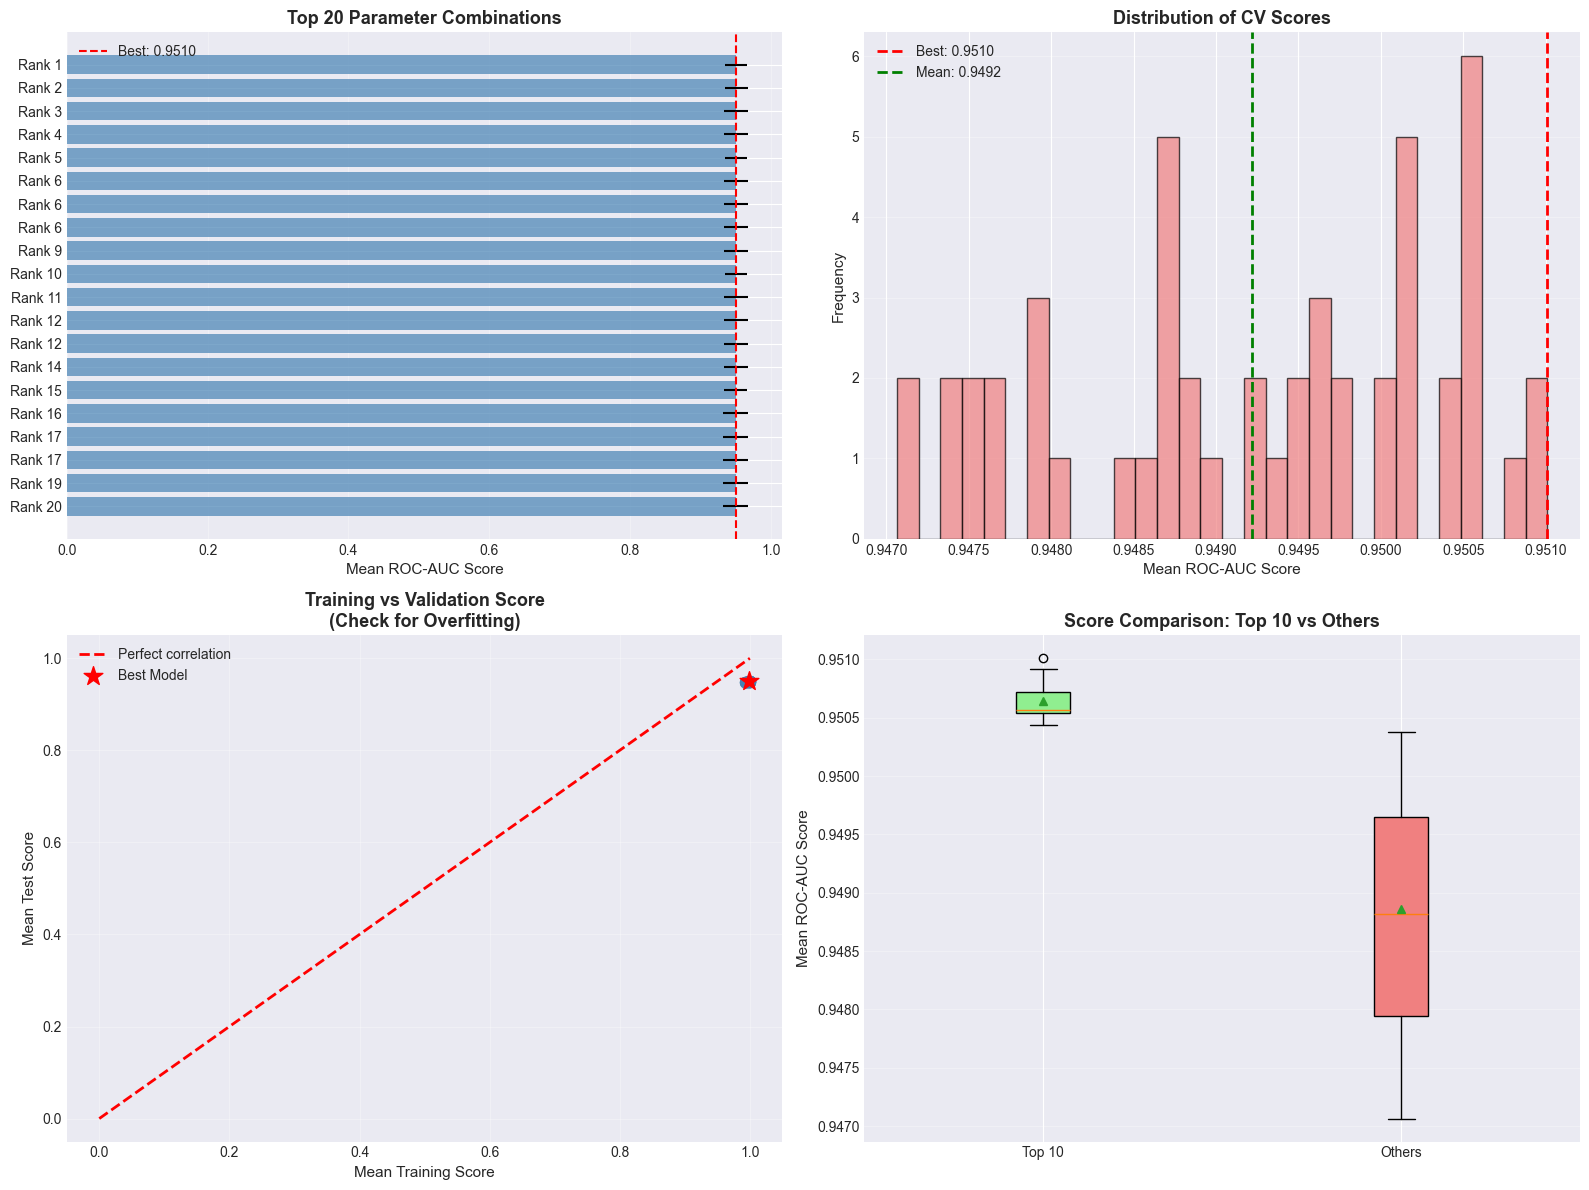


✓ Visualization complete!


In [56]:
# Visualisasi hasil Grid Search
print("VISUALIZING GRID SEARCH RESULTS")
print("="*80)

# Get results dataframe
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')

# Display top 10 parameter combinations
print("\nTop 10 Parameter Combinations:")
print("-"*80)
top_10 = cv_results.head(10)[['rank_test_score', 'mean_test_score', 'std_test_score', 'params']]
for idx, row in top_10.iterrows():
    print(f"\nRank {int(row['rank_test_score'])}:")
    print(f"  Mean ROC-AUC: {row['mean_test_score']:.4f} (± {row['std_test_score']:.4f})")
    print(f"  Parameters: {row['params']}")

# Visualization 1: Top 20 combinations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Top 20 combinations bar chart
top_20 = cv_results.head(20)
axes[0, 0].barh(range(len(top_20)), top_20['mean_test_score'], 
                xerr=top_20['std_test_score'], color='steelblue', alpha=0.7)
axes[0, 0].set_yticks(range(len(top_20)))
axes[0, 0].set_yticklabels([f"Rank {int(r)}" for r in top_20['rank_test_score']])
axes[0, 0].set_xlabel('Mean ROC-AUC Score', fontsize=11)
axes[0, 0].set_title('Top 20 Parameter Combinations', fontsize=13, fontweight='bold')
axes[0, 0].axvline(x=grid_search.best_score_, color='red', linestyle='--', 
                   label=f'Best: {grid_search.best_score_:.4f}')
axes[0, 0].legend()
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].invert_yaxis()

# Plot 2: Score distribution
axes[0, 1].hist(cv_results['mean_test_score'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=grid_search.best_score_, color='red', linestyle='--', linewidth=2,
                   label=f'Best: {grid_search.best_score_:.4f}')
axes[0, 1].axvline(x=cv_results['mean_test_score'].mean(), color='green', linestyle='--', linewidth=2,
                   label=f'Mean: {cv_results["mean_test_score"].mean():.4f}')
axes[0, 1].set_xlabel('Mean ROC-AUC Score', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of CV Scores', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Training vs Test score (check for overfitting)
axes[1, 0].scatter(cv_results['mean_train_score'], cv_results['mean_test_score'], 
                   alpha=0.5, s=50, c='steelblue')
axes[1, 0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect correlation')
axes[1, 0].scatter(cv_results.loc[grid_search.best_index_, 'mean_train_score'],
                   cv_results.loc[grid_search.best_index_, 'mean_test_score'],
                   color='red', s=200, marker='*', label='Best Model', zorder=5)
axes[1, 0].set_xlabel('Mean Training Score', fontsize=11)
axes[1, 0].set_ylabel('Mean Test Score', fontsize=11)
axes[1, 0].set_title('Training vs Validation Score\n(Check for Overfitting)', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Box plot of top 10 vs others
top_10_scores = cv_results.head(10)['mean_test_score']
others_scores = cv_results.iloc[10:]['mean_test_score']

bp = axes[1, 1].boxplot([top_10_scores, others_scores], 
                        labels=['Top 10', 'Others'],
                        patch_artist=True,
                        showmeans=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1, 1].set_ylabel('Mean ROC-AUC Score', fontsize=11)
axes[1, 1].set_title('Score Comparison: Top 10 vs Others', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")
print("="*80)

### Visualization: Parameter Impact Analysis

PARAMETER IMPACT ANALYSIS


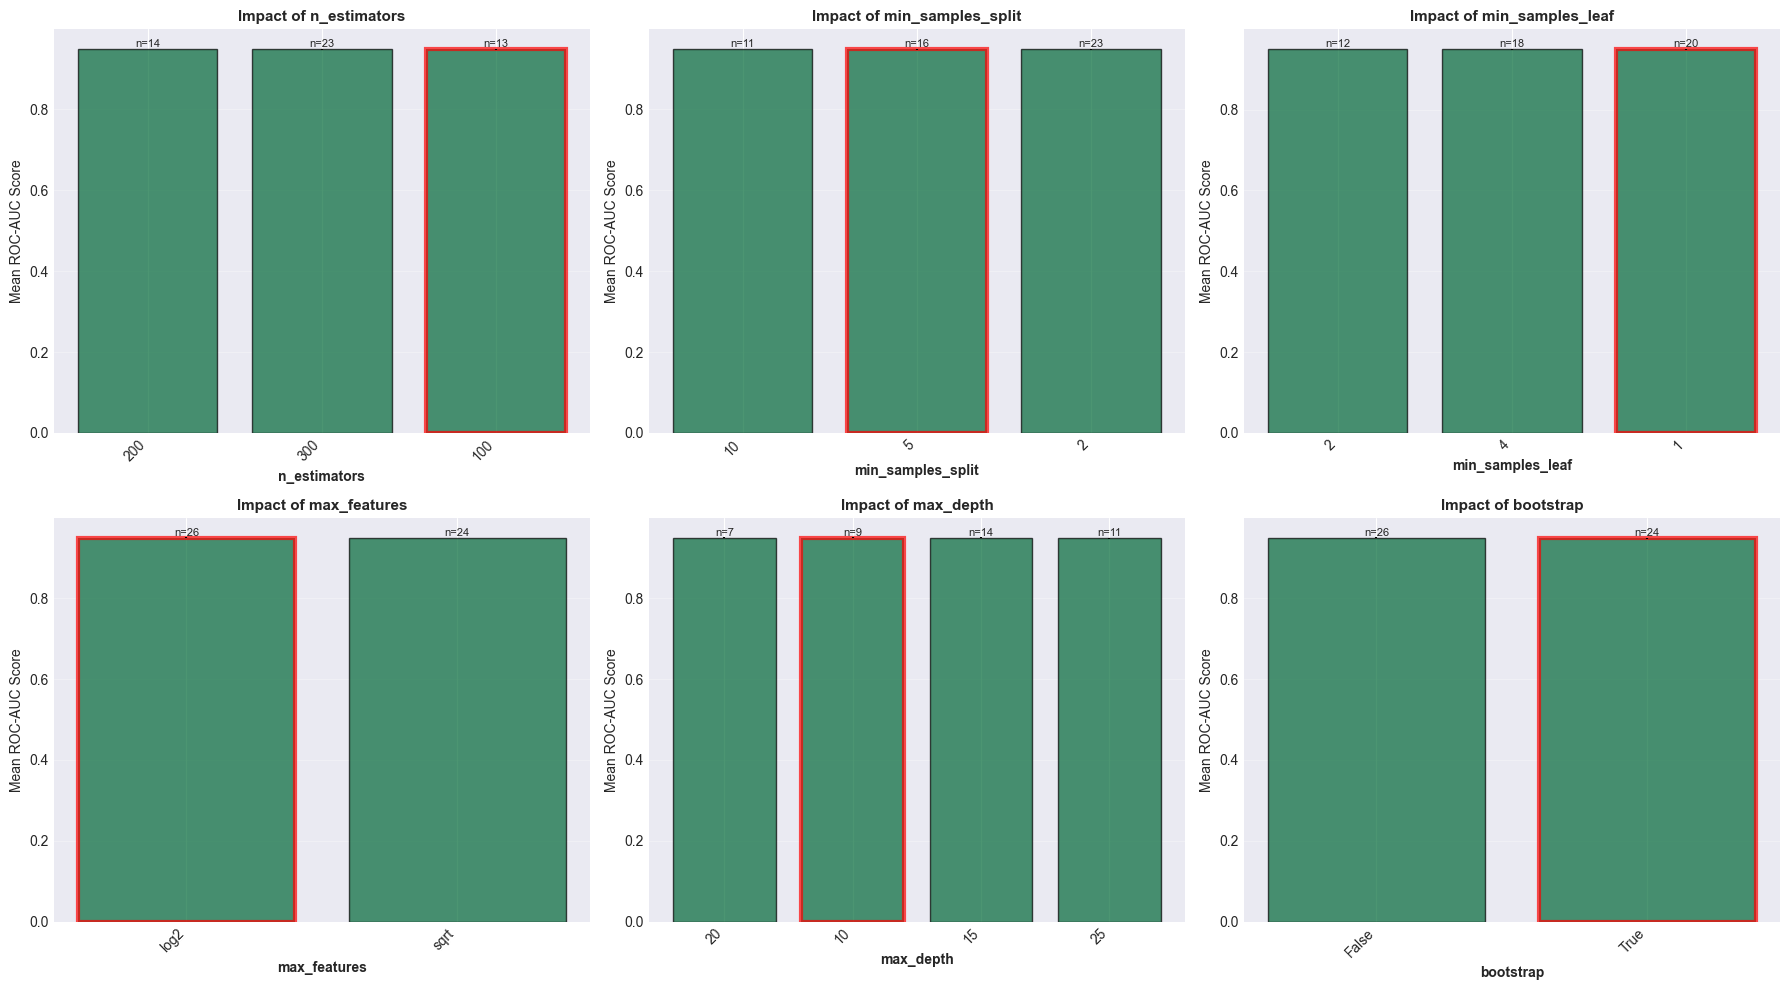


✓ Parameter impact analysis complete!


BEST PARAMETERS SUMMARY
Model: Random Forest
Scenario: 60-40 Split

Optimized Parameters:
   1. n_estimators              = 100
   2. min_samples_split         = 5
   3. min_samples_leaf          = 1
   4. max_features              = log2
   5. max_depth                 = 10
   6. bootstrap                 = True

Performance:
  Cross-Validation ROC-AUC: 0.9510
  Test Set ROC-AUC: 0.9534
  Test Set F1-Score: 0.8595



In [57]:
# Analisis impact setiap parameter terhadap performance
print("PARAMETER IMPACT ANALYSIS")
print("="*80)

# Get parameter names
param_names = list(grid_search.best_params_.keys())

# Create figure untuk visualisasi parameter impact
n_params = len(param_names)
n_cols = 3
n_rows = (n_params + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten() if n_params > 1 else [axes]

for idx, param_name in enumerate(param_names):
    ax = axes[idx]
    
    # Group by parameter value dan hitung mean score
    param_col = f'param_{param_name}'
    
    if param_col in cv_results.columns:
        # Get unique values dan scores
        param_scores = cv_results.groupby(param_col)['mean_test_score'].agg(['mean', 'std', 'count'])
        param_scores = param_scores.sort_values('mean', ascending=False)
        
        # Convert index to string untuk plotting
        x_labels = [str(x) for x in param_scores.index]
        
        # Plot bar chart
        colors_param = plt.cm.RdYlGn(param_scores['mean'] / param_scores['mean'].max())
        bars = ax.bar(range(len(param_scores)), param_scores['mean'], 
                      yerr=param_scores['std'], color=colors_param, alpha=0.7,
                      edgecolor='black', linewidth=1)
        
        ax.set_xticks(range(len(param_scores)))
        ax.set_xticklabels(x_labels, rotation=45, ha='right')
        ax.set_xlabel(param_name, fontsize=10, fontweight='bold')
        ax.set_ylabel('Mean ROC-AUC Score', fontsize=10)
        ax.set_title(f'Impact of {param_name}', fontsize=11, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Highlight best value
        best_value = str(grid_search.best_params_[param_name])
        if best_value in x_labels:
            best_idx = x_labels.index(best_value)
            bars[best_idx].set_edgecolor('red')
            bars[best_idx].set_linewidth(3)
        
        # Add count labels
        for i, (val, count) in enumerate(zip(param_scores['mean'], param_scores['count'])):
            ax.text(i, val, f'n={int(count)}', ha='center', va='bottom', fontsize=8)

# Remove extra subplots
for idx in range(n_params, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

print("\n✓ Parameter impact analysis complete!")
print("="*80)

# Summary: Best parameters
print("\n\nBEST PARAMETERS SUMMARY")
print("="*80)
print(f"Model: {best_model_name}")
print(f"Scenario: {best_scenario}")
print(f"\nOptimized Parameters:")
for i, (param, value) in enumerate(grid_search.best_params_.items(), 1):
    print(f"  {i:2d}. {param:25s} = {value}")

print(f"\nPerformance:")
print(f"  Cross-Validation ROC-AUC: {grid_search.best_score_:.4f}")
if X_tune_test is not None:
    print(f"  Test Set ROC-AUC: {roc_auc_tuned:.4f}")
    print(f"  Test Set F1-Score: {f1_tuned:.4f}")

print(f"\n{'='*80}")

BEST MODEL & SCENARIO SELECTION

BEST MODEL OVERALL (Based on ROC-AUC):
   Scenario: 60-40 Split
   Model: Random Forest
   Accuracy: 0.9217
   Precision: 0.7811
   Recall: 0.9812
   F1-Score: 0.8698
   ROC-AUC: 0.9550

BEST MODEL PER SCENARIO (Based on ROC-AUC):

80-20 Split:
   Best Model: LightGBM
   F1-Score: 0.8621
   ROC-AUC: 0.9474

70-30 Split:
   Best Model: Gradient Boosting
   F1-Score: 0.8517
   ROC-AUC: 0.9532

60-40 Split:
   Best Model: Random Forest
   F1-Score: 0.8698
   ROC-AUC: 0.9550

10-Fold CV:
   Best Model: XGBoost
   F1-Score: 0.8584
   ROC-AUC: 0.9524

SCENARIO COMPARISON:

Average ROC-AUC by Scenario:
   60-40 Split: 0.9541
   70-30 Split: 0.9511
   10-Fold CV: 0.9505
   80-20 Split: 0.9462

INSIGHTS:
   • 60-40 Split performs best
   • Larger test set provides more thorough validation
   • May be preferred when validation robustness is critical


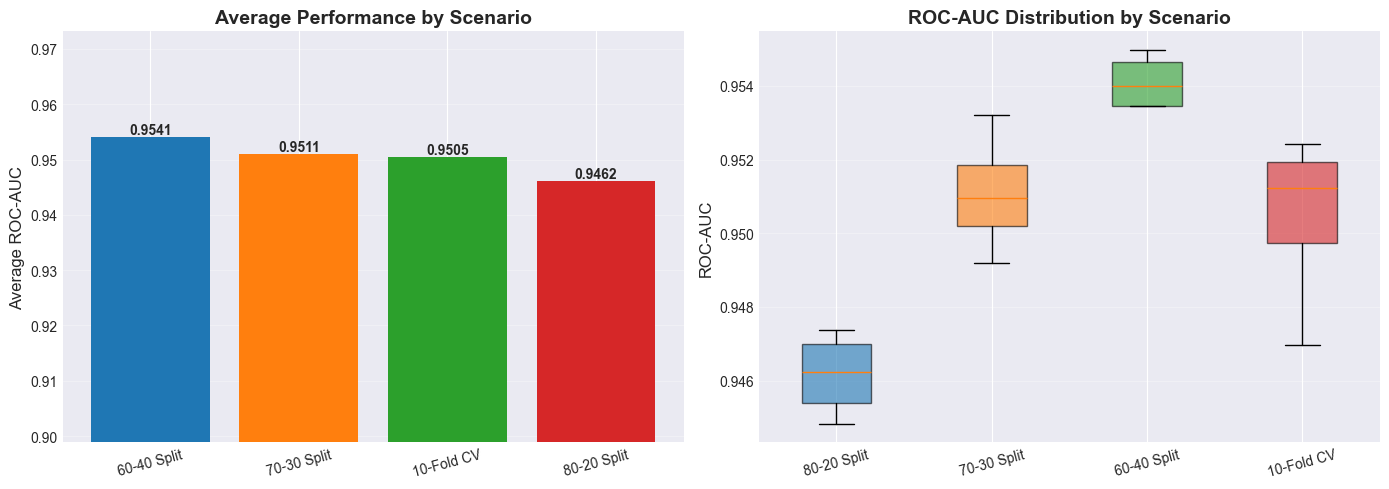


✓ Analysis complete!


In [58]:
# Pilih best model berdasarkan ROC-AUC (Area Under Curve - metrik terbaik untuk klasifikasi)
print("BEST MODEL & SCENARIO SELECTION")
print("="*80)

# Cari best model overall berdasarkan ROC-AUC
best_overall = comparison_df.sort_values('ROC-AUC', ascending=False).iloc[0]

print(f"\nBEST MODEL OVERALL (Based on ROC-AUC):")
print(f"   Scenario: {best_overall['Scenario']}")
print(f"   Model: {best_overall['Model']}")
print(f"   Accuracy: {best_overall['Accuracy']:.4f}")
print(f"   Precision: {best_overall['Precision']:.4f}")
print(f"   Recall: {best_overall['Recall']:.4f}")
print(f"   F1-Score: {best_overall['F1-Score']:.4f}")
print(f"   ROC-AUC: {best_overall['ROC-AUC']:.4f}")

# Analisis per scenario
print("\n" + "="*80)
print("BEST MODEL PER SCENARIO (Based on ROC-AUC):")
print("="*80)

for scenario_name in ['80-20 Split', '70-30 Split', '60-40 Split', '10-Fold CV']:
    best_per_scenario = comparison_df[comparison_df['Scenario'] == scenario_name].sort_values('ROC-AUC', ascending=False).iloc[0]
    print(f"\n{scenario_name}:")
    print(f"   Best Model: {best_per_scenario['Model']}")
    print(f"   F1-Score: {best_per_scenario['F1-Score']:.4f}")
    print(f"   ROC-AUC: {best_per_scenario['ROC-AUC']:.4f}")

# Rekomendasi
print("\n" + "="*80)
print("SCENARIO COMPARISON:")
print("="*80)

avg_by_scenario = comparison_df.groupby('Scenario')['ROC-AUC'].mean().sort_values(ascending=False)
print("\nAverage ROC-AUC by Scenario:")
for scenario, score in avg_by_scenario.items():
    print(f"   {scenario}: {score:.4f}")

print("\nINSIGHTS:")
best_scenario = avg_by_scenario.index[0]

if best_scenario == '10-Fold CV':
    print("   • 10-Fold Cross Validation performs best")
    print("   • K-Fold provides more robust evaluation through multiple train/test splits")
    print("   • Reduces variance and gives more reliable performance estimates")
elif best_scenario == '80-20 Split':
    print("   • 80-20 Split performs best")
    print("   • Larger training set (80%) helps model learn better patterns")
    print("   • Good balance between training data size and test set size")
elif best_scenario == '70-30 Split':
    print("   • 70-30 Split performs best")
    print("   • Moderate training set with larger test set for better validation")
    print("   • Good balance for moderate-sized datasets")
else:  # 60-40 Split
    print("   • 60-40 Split performs best")
    print("   • Larger test set provides more thorough validation")
    print("   • May be preferred when validation robustness is critical")

# Visualisasi perbandingan scenario
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart - Average ROC-AUC by Scenario
axes[0].bar(avg_by_scenario.index, avg_by_scenario.values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0].set_ylabel('Average ROC-AUC', fontsize=12)
axes[0].set_title('Average Performance by Scenario', fontsize=14, fontweight='bold')
axes[0].set_ylim([avg_by_scenario.min() * 0.95, avg_by_scenario.max() * 1.02])
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=15)

# Add value labels
for i, (scenario, score) in enumerate(avg_by_scenario.items()):
    axes[0].text(i, score, f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# Box plot - Distribution of ROC-AUC by Scenario
scenario_data = [comparison_df[comparison_df['Scenario'] == s]['ROC-AUC'].values for s in ['80-20 Split', '70-30 Split', '60-40 Split', '10-Fold CV']]
bp = axes[1].boxplot(scenario_data, labels=['80-20 Split', '70-30 Split', '60-40 Split', '10-Fold CV'], patch_artist=True)

for patch, color in zip(bp['boxes'], ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[1].set_ylabel('ROC-AUC', fontsize=12)
axes[1].set_title('ROC-AUC Distribution by Scenario', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

print("\n✓ Analysis complete!")
print("="*80)

CONFUSION MATRIX - BEST MODEL


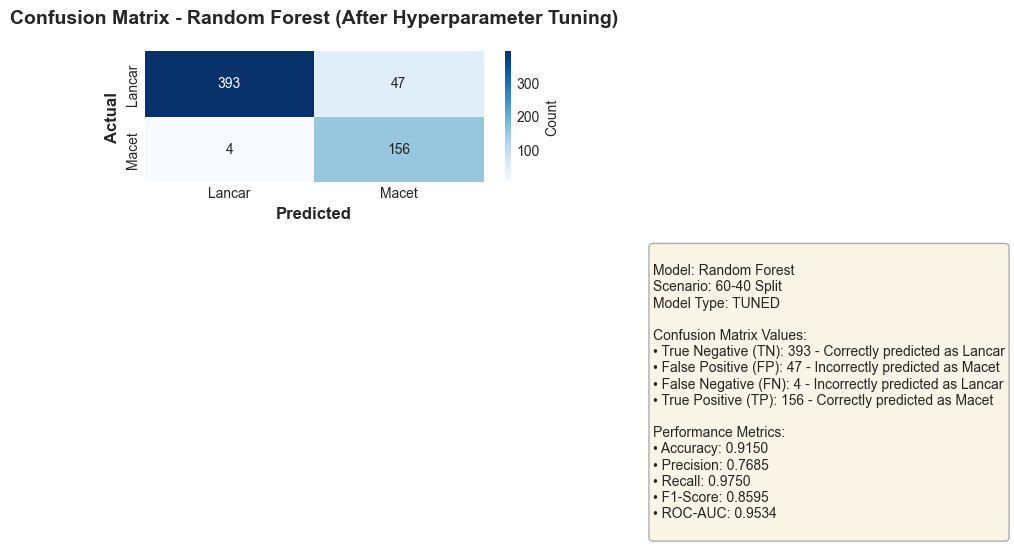


Model: Random Forest
Scenario: 60-40 Split
ROC-AUC (After Tuning): 0.9534
ROC-AUC (Before Tuning): 0.9550
Improvement: -0.0015



In [59]:
# Visualisasi Confusion Matrix untuk Best Model sebelum disimpan
print("CONFUSION MATRIX - BEST MODEL")
print("="*80)

# Prediksi dengan best tuned model
y_pred_final = best_tuned_model.predict(X_tune_test)
cm_final = confusion_matrix(y_tune_test, y_pred_final)

# Hitung metrik dari confusion matrix
TN = cm_final[0, 0]
FP = cm_final[0, 1]
FN = cm_final[1, 0]
TP = cm_final[1, 1]

# Plot confusion matrix dengan seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Lancar', 'Macet'], 
            yticklabels=['Lancar', 'Macet'],
            cbar_kws={'label': 'Count'})

plt.title(f'Confusion Matrix - {best_overall["Model"]} (After Hyperparameter Tuning)', 
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')

# Tambahkan text box dengan informasi detail
textstr = f'''
Model: {best_overall["Model"]}
Scenario: {best_scenario}
Model Type: TUNED

Confusion Matrix Values:
• True Negative (TN): {TN} - Correctly predicted as Lancar
• False Positive (FP): {FP} - Incorrectly predicted as Macet
• False Negative (FN): {FN} - Incorrectly predicted as Lancar
• True Positive (TP): {TP} - Correctly predicted as Macet

Performance Metrics:
• Accuracy: {accuracy_tuned:.4f}
• Precision: {precision_tuned:.4f}
• Recall: {recall_tuned:.4f}
• F1-Score: {f1_tuned:.4f}
• ROC-AUC: {roc_auc_tuned:.4f}
'''

plt.text(1.5, -0.5, textstr, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

# Print summary
print(f"\nModel: {best_overall['Model']}")
print(f"Scenario: {best_scenario}")
print(f"ROC-AUC (After Tuning): {roc_auc_tuned:.4f}")
print(f"ROC-AUC (Before Tuning): {best_overall['ROC-AUC']:.4f}")
print(f"Improvement: {improvement:.4f}")
print("\n" + "="*80)

In [60]:
print("SAVING BEST MODEL (AFTER HYPERPARAMETER TUNING)")
print("="*80)

# Gunakan model yang sudah di-tune dari grid search
# Jika tuning meningkatkan performa, gunakan model hasil tuning
# Jika tidak, gunakan model original

improvement = roc_auc_tuned - best_overall['ROC-AUC']

if improvement >= 0:
    # Use tuned model
    best_model = best_tuned_model
    final_roc_auc = roc_auc_tuned
    final_f1 = f1_tuned if f1_tuned is not None else best_overall['F1-Score']
    model_type = "TUNED"
    print(f"Using HYPERPARAMETER TUNED model")
    print(f"  Improvement: +{improvement:.4f} ROC-AUC")
else:
    # Use original model (re-train dengan parameter original)
    if best_overall['Model'] == 'Random Forest':
        best_model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=10, min_samples_leaf=4, random_state=42, n_jobs=-1)
    elif best_overall['Model'] == 'Gradient Boosting':
        best_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    elif best_overall['Model'] == 'XGBoost':
        best_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='logloss', use_label_encoder=False)
    else:  # LightGBM
        best_model = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1)
    
    best_model.fit(X_tune_train, y_tune_train)
    final_roc_auc = best_overall['ROC-AUC']
    final_f1 = best_overall['F1-Score']
    model_type = "ORIGINAL"
    print(f" Using ORIGINAL model (tuning didn't improve performance)")
    print(f"  Tuning impact: {improvement:.4f} ROC-AUC")

scaler_to_save = scaler_tune

print(f"\nFinal Model: {best_overall['Model']} ({model_type})")
print(f"Scenario: {best_scenario}")
print(f"ROC-AUC: {final_roc_auc:.4f}")

# Timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Create model directory with timestamp
model_dir = f'models/model_{timestamp}'
os.makedirs(model_dir, exist_ok=True)
print(f"Created model directory: {model_dir}")

# Save model
model_filename = f'{model_dir}/best_model_{best_overall["Model"].lower().replace(" ", "_")}.joblib'
joblib.dump(best_model, model_filename)
print(f"Model saved: {model_filename}")

# Save encoders
encoders_filename = f'{model_dir}/label_encoders.joblib'
joblib.dump(label_encoders, encoders_filename)
print(f"Encoders saved: {encoders_filename}")

# Save target encoder
target_encoder_filename = f'{model_dir}/target_encoder.joblib'
joblib.dump(target_encoder, target_encoder_filename)
print(f"Target encoder saved: {target_encoder_filename}")

# Save scaler
scaler_filename = f'{model_dir}/scaler.joblib'
joblib.dump(scaler_to_save, scaler_filename)
print(f"Scaler saved: {scaler_filename}")

# Save metadata
metadata = {
    'model_name': best_overall['Model'],
    'model_type': model_type,
    'scenario_type': best_scenario,
    'timestamp': timestamp,
    'model_directory': model_dir,
    'accuracy': float(best_overall['Accuracy']),
    'precision': float(best_overall['Precision']),
    'recall': float(best_overall['Recall']),
    'f1_score': float(final_f1),
    'roc_auc': float(final_roc_auc),
    'roc_auc_before_tuning': float(best_overall['ROC-AUC']),
    'roc_auc_after_tuning': float(roc_auc_tuned),
    'tuning_improvement': float(improvement),
    'hyperparameters': grid_search.best_params_ if model_type == "TUNED" else "original_parameters",
    'features': feature_columns,
    'target_classes': target_encoder.classes_.tolist(),
    'model_file': model_filename,
    'encoders_file': encoders_filename,
    'target_encoder_file': target_encoder_filename,
    'scaler_file': scaler_filename,
    'train_test_split': best_scenario
}

metadata_filename = f'{model_dir}/model_metadata.json'
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"Metadata saved: {metadata_filename}")

print(f"\n{'='*80}")
print(f"BEST MODEL SAVED SUCCESSFULLY")
print(f"{'='*80}")
print(f"Directory: {model_dir}")
print(f"Model Type: {model_type}")
print(f"Scenario: {best_scenario}")
print(f"Model: {best_overall['Model']}")
print(f"ROC-AUC: {final_roc_auc:.4f}")
print(f"F1-Score: {final_f1:.4f}")
if model_type == "TUNED":
    print(f"\nHyperparameter Tuning Results:")
    print(f"  Before: {best_overall['ROC-AUC']:.4f}")
    print(f"  After: {roc_auc_tuned:.4f}")
    print(f"  Improvement: +{improvement:.4f}")
    print(f"\nOptimized Hyperparameters:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
print(f"\nFiles saved:")
print(f"  1. {os.path.basename(model_filename)}")
print(f"  2. {os.path.basename(encoders_filename)}")
print(f"  3. {os.path.basename(target_encoder_filename)}")
print(f"  4. {os.path.basename(scaler_filename)}")
print(f"  5. {os.path.basename(metadata_filename)}")

SAVING BEST MODEL (AFTER HYPERPARAMETER TUNING)
 Using ORIGINAL model (tuning didn't improve performance)
  Tuning impact: -0.0015 ROC-AUC

Final Model: Random Forest (ORIGINAL)
Scenario: 60-40 Split
ROC-AUC: 0.9550
Created model directory: models/model_20260112_100139
Model saved: models/model_20260112_100139/best_model_random_forest.joblib
Encoders saved: models/model_20260112_100139/label_encoders.joblib
Target encoder saved: models/model_20260112_100139/target_encoder.joblib
Scaler saved: models/model_20260112_100139/scaler.joblib
Metadata saved: models/model_20260112_100139/model_metadata.json

BEST MODEL SAVED SUCCESSFULLY
Directory: models/model_20260112_100139
Model Type: ORIGINAL
Scenario: 60-40 Split
Model: Random Forest
ROC-AUC: 0.9550
F1-Score: 0.8698

Files saved:
  1. best_model_random_forest.joblib
  2. label_encoders.joblib
  3. target_encoder.joblib
  4. scaler.joblib
  5. model_metadata.json


---

## **RINGKASAN WORKFLOW YANG TELAH DILAKSANAKAN**

### **Tahapan Lengkap:**

```
┌─────────────────────────────────────────────────────────────────────┐
│ 1. DATA PREPARATION                                                 │
│    ├─ Load data                                                     │
│    ├─ Feature engineering (Usia)                                    │
│    └─ Data preprocessing & encoding                                 │
└─────────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────────┐
│ 2. FEATURE SELECTION ✓                                              │
│    ├─ Chi-Square Test                                               │
│    ├─ Mutual Information                                            │
│    ├─ Random Forest Importance                                      │
│    ├─ RFE (Recursive Feature Elimination)                           │
│    └─ OUTPUT: Dataset dengan atribut terpilih                       │
└─────────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────────┐
│ 3. EKSPLORASI TEKNIK PEMISAHAN DATA ✓                               │
│    Menggunakan dataset hasil feature selection                      │
│    ├─ 80-20 Split (Stratified Random Sampling)                      │
│    ├─ 70-30 Split (Stratified Random Sampling)                      │
│    ├─ 60-40 Split (Stratified Random Sampling)                      │
│    └─ 10-Fold Stratified Cross Validation                           │
│    OUTPUT: 4 skenario dataset untuk evaluasi                        │
└─────────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────────┐
│ 4. EKSPLORASI MODEL DENGAN SEMUA SKENARIO ✓                         │
│    Training 4 model × 4 skenario = 16 kombinasi                     │
│    ├─ Random Forest                                                 │
│    ├─ Gradient Boosting                                             │
│    ├─ XGBoost                                                       │
│    └─ LightGBM                                                      │
│    OUTPUT: Best model & best scenario dataset                       │
└─────────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────────┐
│ 5. HYPERPARAMETER TUNING ✓                                          │
│    Menggunakan BEST MODEL + BEST SCENARIO DATASET                   │
│    ├─ Randomized Search CV                                          │
│    ├─ 5-Fold Stratified CV                                          │
│    └─ Scoring: ROC-AUC                                              │
│    OUTPUT: Model optimal dengan parameter terbaik                   │
└─────────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────────┐
│ 6. CONFUSION MATRIX VISUALIZATION ✓                                 │
│    Model terbaik yang sudah di-tuning                               │
│    ├─ True Positive / True Negative                                 │
│    ├─ False Positive / False Negative                               │
│    └─ Analisis error patterns                                       │
│    OUTPUT: Visualisasi performa final                               │
└─────────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────────┐
│ 7. SAVE MODEL ✓                                                     │
│    ├─ Best model (after tuning)                                     │
│    ├─ Label encoders                                                │
│    ├─ Target encoder                                                │
│    ├─ Scaler                                                        │
│    └─ Metadata                                                      │
│    OUTPUT: Model siap deploy                                        │
└─────────────────────────────────────────────────────────────────────┘
```
